In [1]:
import os
import warnings
warnings.filterwarnings('ignore')
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
import numpy as np
from nsepy import get_history
from datetime import date
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import yfinance as yf

In [80]:
df = pd.read_csv('RELIANCE.NS.csv')
df

Date         Open         High          Low        Close  \
0     01-01-2016   500.158997   504.666260   499.366516   502.907928   
1     04-01-2016   497.781525   502.140198   488.717438   492.977081   
2     05-01-2016   495.453583   500.258057   493.819092   497.855835   
3     06-01-2016   499.069336   514.324707   495.503113   511.253815   
4     07-01-2016   505.731171   509.173553   499.292206   501.867798   
...          ...          ...          ...          ...          ...   
1510  11-02-2022  2373.250000  2384.500000  2344.100098  2376.399902   
1511  14-02-2022  2340.250000  2354.949951  2313.000000  2338.550049   
1512  15-02-2022  2351.199951  2423.899902  2335.699951  2417.949951   
1513  16-02-2022  2430.000000  2433.000000  2395.949951  2412.949951   
1514  17-02-2022  2420.100098  2454.899902  2410.000000  2443.500000   

        Adj Close    Volume  
0      484.996368   2499742  
1      475.419189  13923887  
2      480.124176   6897687  
3      493.044983  12349673  
4      483.993286   9109980  
...           ...       ...  
1510  2376.399902   7357863  
1511  2338.550049   4947109  
1512  2417.949951   5174646  
1513  2412.949951   4796294  
1514  2443.500000   5931774  

[1515 rows x 7 columns]

In [81]:
df.dtypes

Date          object
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object

In [82]:
Total = df.isnull().sum().sort_values(ascending=False)          

Percent = (df.isnull().sum()*100/df.isnull().count()).sort_values(ascending=False)   

missing_data = pd.concat([Total, Percent], axis = 1, keys = ['Total', 'Percentage of Missing Values'])    
missing_data

Total  Percentage of Missing Values
Volume         0                           0.0
Adj Close      0                           0.0
Close          0                           0.0
Low            0                           0.0
High           0                           0.0
Open           0                           0.0
Date           0                           0.0

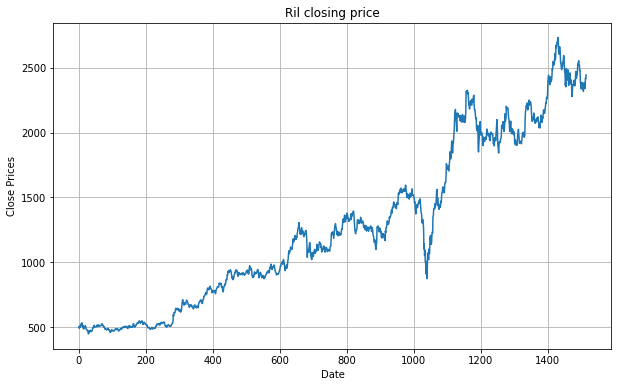

In [83]:
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Close Prices')
plt.plot(df['Close'])
plt.title('Ril closing price')
plt.show()

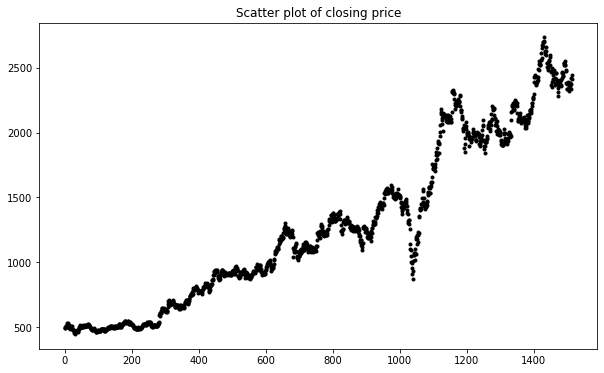

In [84]:
plt.figure(figsize=(10,6))
df_close = df['Close']
df_close.plot(style='k.')
plt.title('Scatter plot of closing price')
plt.show()

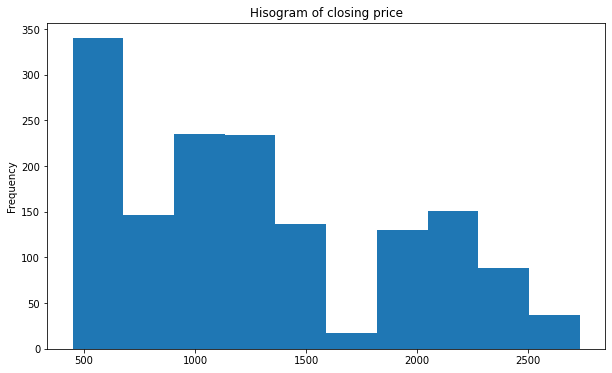

In [85]:
plt.figure(figsize=(10,6))
df_close = df['Close']
df_close.plot(style='k.',kind='hist')
plt.title('Hisogram of closing price')
plt.show()

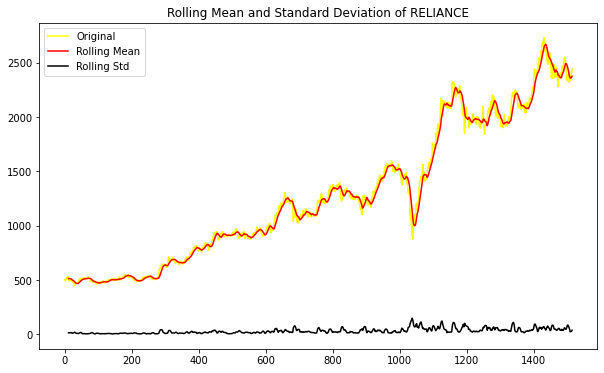

Results of dickey fuller test
Test Statistics                  -0.225584
p-value                           0.935403
No. of lags used                  0.000000
Number of observations used    1514.000000
critical value (1%)              -3.434677
critical value (5%)              -2.863451
critical value (10%)             -2.567787
dtype: float64


In [86]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='yellow',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation of RELIANCE')
    plt.show(block=False)
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)

test_stationarity(df['Close'])

<Figure size 720x432 with 0 Axes>

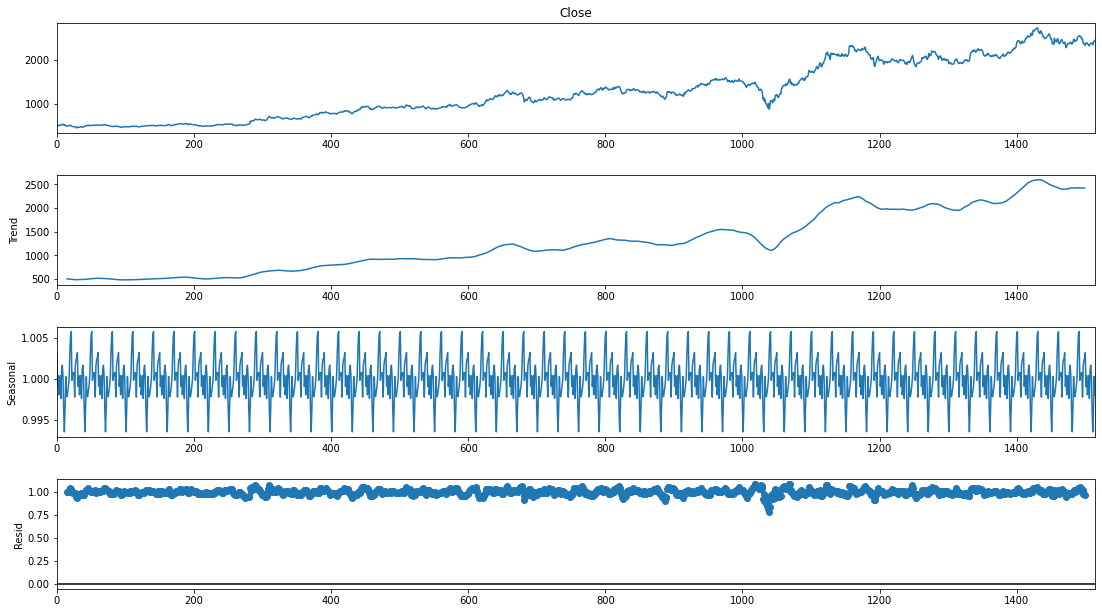

In [170]:
result = seasonal_decompose(df_close, model='multiplicative', freq = 30)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(16, 9)

No handles with labels found to put in legend.


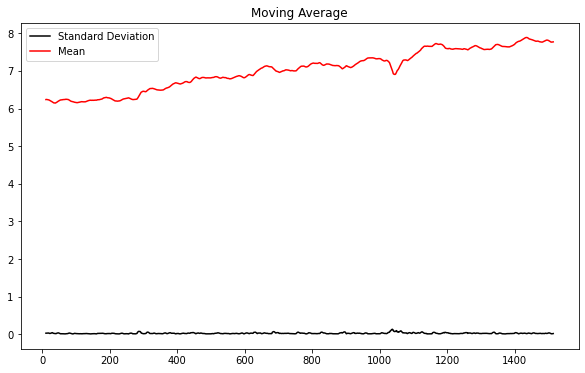

In [171]:
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
df_log = np.log(df['Close'])
moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend()
plt.show()

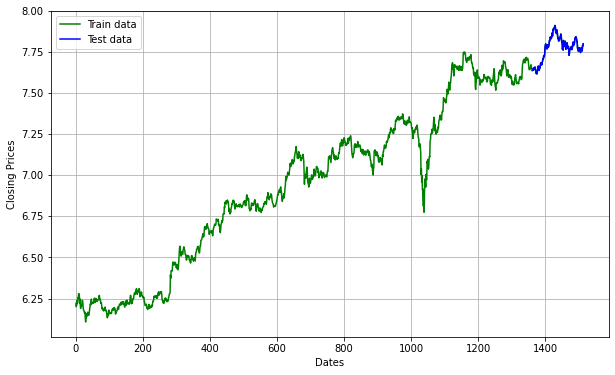

In [172]:
train_data, test_data = df_log[3:int(len(df_log)*0.90)], df_log[int(len(df_log)*0.90):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_log, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()

In [173]:
model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
test='adf',       # use adftest to find optimal 'd'
max_p=3, max_q=3, # maximum p and q
m=1,              # frequency of series
d=None,           # let model determine 'd'
seasonal=False,   # No Seasonality
start_P=0, 
D=0, 
trace=True,
error_action='ignore',  
suppress_warnings=True, 
stepwise=True)
print(model_autoARIMA.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-6896.935, Time=0.58 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-6896.217, Time=1.34 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-6896.071, Time=0.31 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-6894.994, Time=0.22 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-6894.559, Time=0.70 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 3.181 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1360
Model:               SARIMAX(0, 1, 0)   Log Likelihood                3450.467
Date:                Mon, 28 Feb 2022   AIC                          -6896.935
Time:                        03:38:37   BIC                          -6886.506
Sample:                             0   HQIC                         -6893.031
                               - 1360                                  

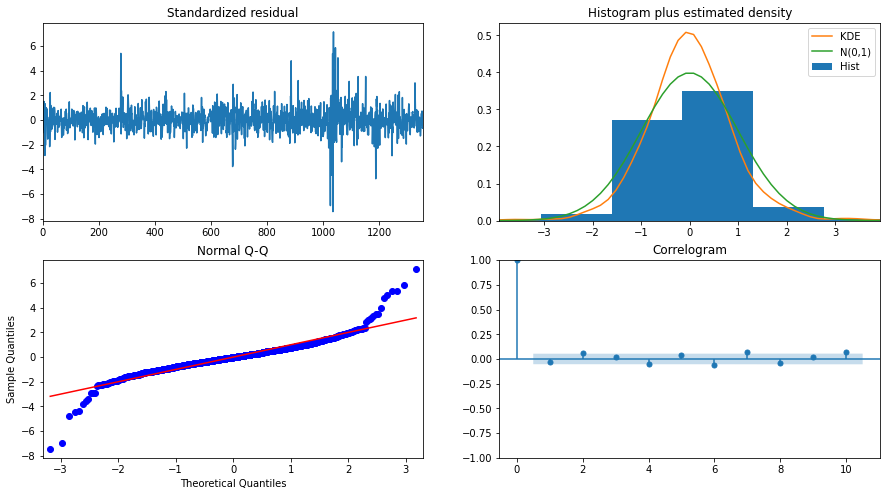

In [174]:
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

In [175]:
model = ARIMA(train_data, order=(3, 1, 2))
fitted = model.fit(disp=-1)
print(fitted.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 1359
Model:                 ARIMA(3, 1, 2)   Log Likelihood                3463.616
Method:                       css-mle   S.D. of innovations              0.019
Date:                Mon, 28 Feb 2022   AIC                          -6913.231
Time:                        03:38:42   BIC                          -6876.730
Sample:                             1   HQIC                         -6899.566
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0010      0.001      1.975      0.048       8e-06       0.002
ar.L1.D.Close    -1.5425      0.105    -14.743      0.000      -1.748      -1.337
ar.L2.D.Close    -0.7536      0.110     

In [176]:
# Forecast

fc, se, conf = fitted.forecast(152, alpha=0.05)  # 95% confidence

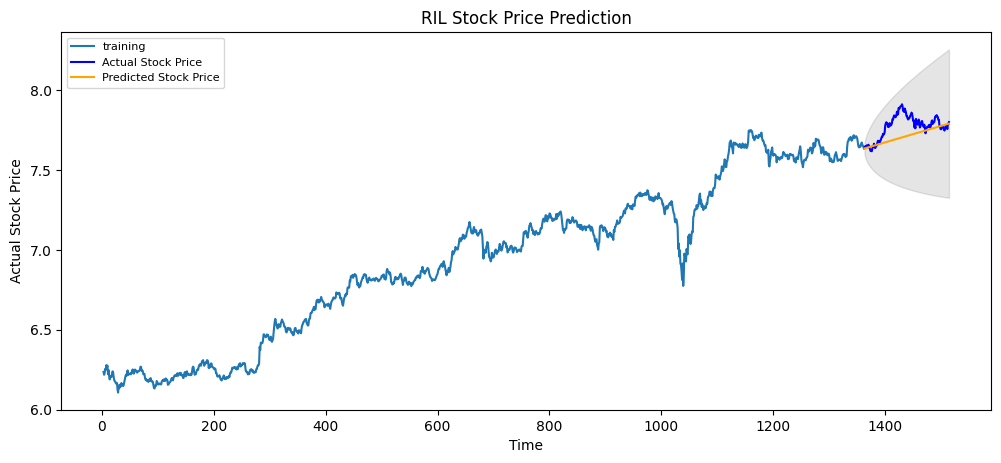

In [177]:
fc_series = pd.Series(fc, index=test_data.index)
lower_series = pd.Series(conf[:, 0], index=test_data.index)
upper_series = pd.Series(conf[:, 1], index=test_data.index)
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, color = 'blue', label='Actual Stock Price')
plt.plot(fc_series, color = 'orange',label='Predicted Stock Price')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.10)
plt.title('RIL Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Actual Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [178]:
from sklearn.metrics import  mean_squared_error
rmse = mean_squared_error(test_data,fc_series,squared=False)
print(rmse)

0.08719840779589745


In [179]:
mape=np.mean(np.abs((test_data - fc_series) / test_data)) * 100
mape

0.8369564634939195

In [19]:
#2 CIPLA.NS.csv

In [33]:
df = pd.read_csv('CIPLA.NS.csv')
df

Date        Open        High         Low       Close   Adj Close  \
0     2016-01-01  653.200012  658.450012  648.500000  655.349976  638.705994   
1     2016-01-04  652.049988  653.799988  639.400024  645.650024  629.252380   
2     2016-01-05  646.200012  649.950012  638.049988  640.849976  624.574280   
3     2016-01-06  639.700012  655.950012  638.700012  652.099976  635.538513   
4     2016-01-07  648.000000  650.000000  629.000000  637.450012  621.260620   
...          ...         ...         ...         ...         ...         ...   
1510  2022-02-11  956.500000  976.049988  953.000000  958.500000  958.500000   
1511  2022-02-14  947.000000  962.900024  938.849976  954.900024  954.900024   
1512  2022-02-15  916.549988  938.799988  912.299988  921.849976  921.849976   
1513  2022-02-16  938.000000  940.250000  920.099976  933.099976  933.099976   
1514  2022-02-17  934.799988  955.500000  925.700012  928.200012  928.200012   

       Volume  
0      556012  
1      631534  
2      642269  
3     1234096  
4      732335  
...       ...  
1510  1292417  
1511  2346622  
1512  8304774  
1513  2480569  
1514  2843010  

[1515 rows x 7 columns]

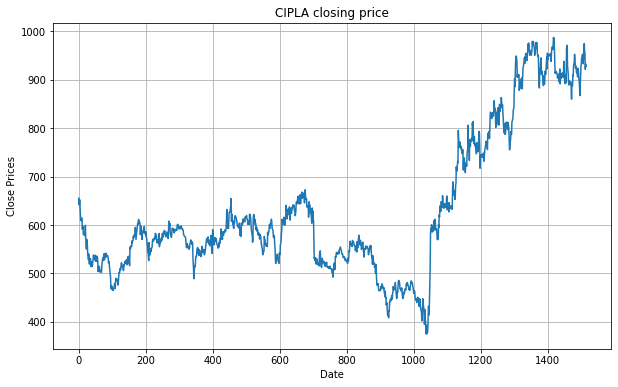

In [34]:
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Close Prices')
plt.plot(df['Close'])
plt.title('CIPLA closing price')
plt.show()

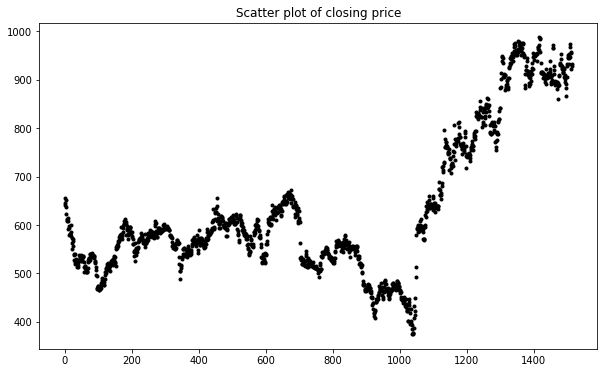

In [35]:
plt.figure(figsize=(10,6))
df_close = df['Close']
df_close.plot(style='k.')
plt.title('Scatter plot of closing price')
plt.show()

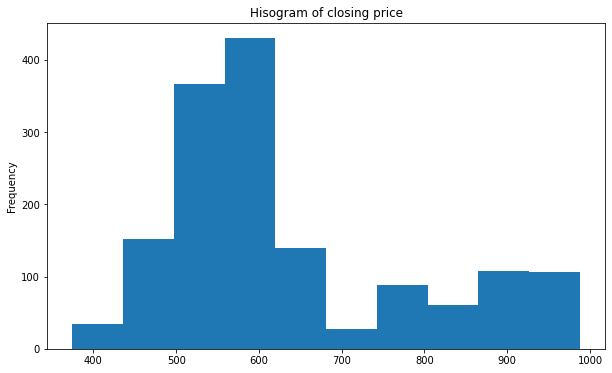

In [36]:
plt.figure(figsize=(10,6))
df_close = df['Close']
df_close.plot(style='k.',kind='hist')
plt.title('Hisogram of closing price')
plt.show()

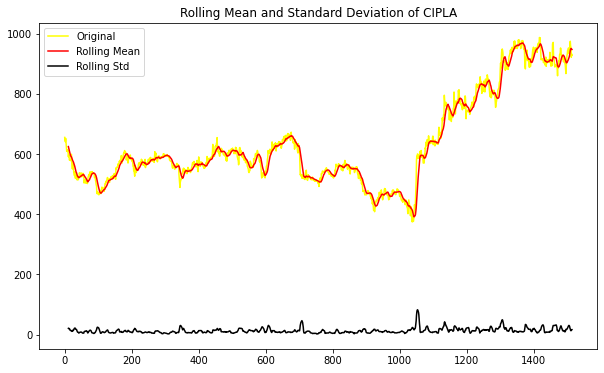

Results of dickey fuller test
Test Statistics                  -0.621817
p-value                           0.865976
No. of lags used                  1.000000
Number of observations used    1513.000000
critical value (1%)              -3.434679
critical value (5%)              -2.863452
critical value (10%)             -2.567788
dtype: float64


In [37]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='yellow',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation of CIPLA')
    plt.show(block=False)
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)

test_stationarity(df['Close'])

<Figure size 720x432 with 0 Axes>

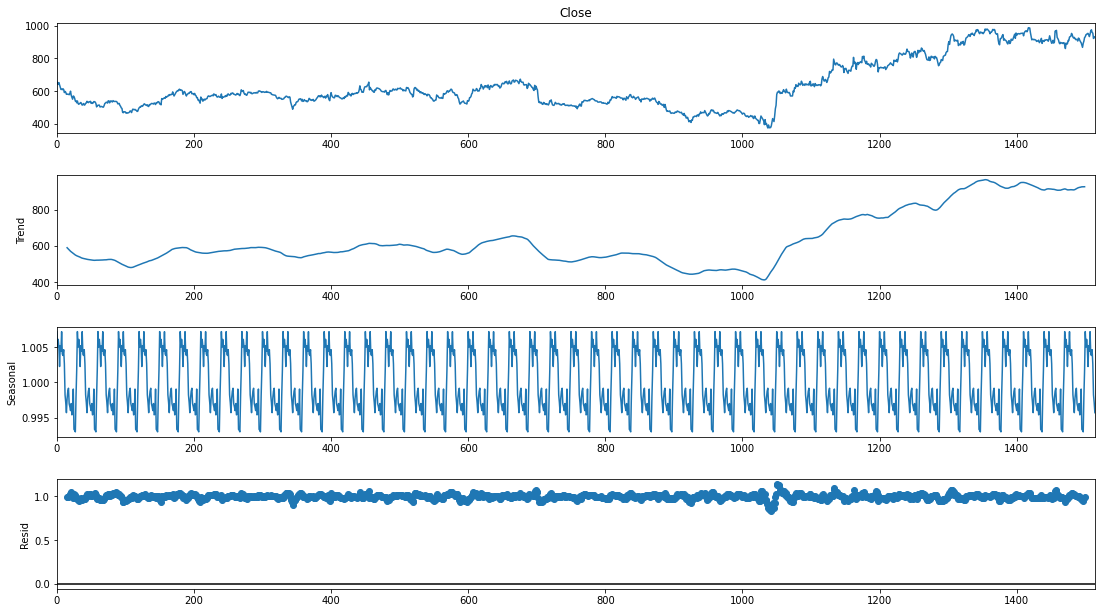

In [25]:
result = seasonal_decompose(df_close, model='multiplicative', freq = 30)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(16, 9)

No handles with labels found to put in legend.


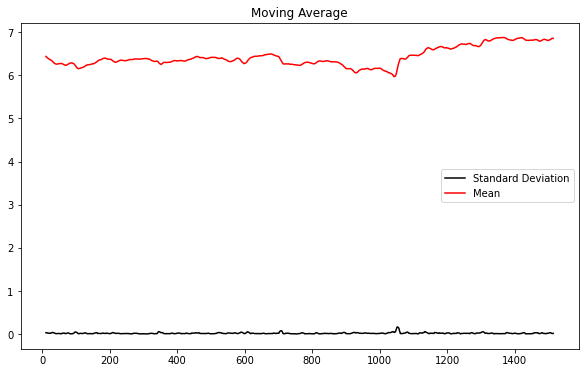

In [26]:
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
df_log = np.log(df['Close'])
moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend()
plt.show()

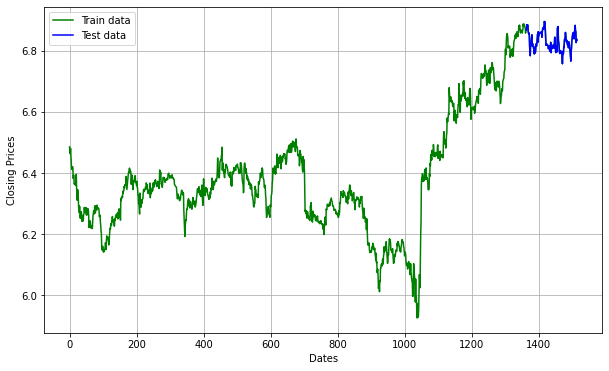

In [27]:
train_data, test_data = df_log[3:int(len(df_log)*0.9)], df_log[int(len(df_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_log, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()

In [28]:
model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
test='adf',       # use adftest to find optimal 'd'
max_p=3, max_q=3, # maximum p and q
m=1,              # frequency of series
d=None,           # let model determine 'd'
seasonal=False,   # No Seasonality
start_P=0, 
D=0, 
trace=True,
error_action='ignore',  
suppress_warnings=True, 
stepwise=True)
print(model_autoARIMA.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-7143.181, Time=0.42 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-7144.143, Time=0.39 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-7144.016, Time=0.88 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-7144.820, Time=0.25 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-7142.329, Time=0.96 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 2.930 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1360
Model:               SARIMAX(0, 1, 0)   Log Likelihood                3573.410
Date:                Sat, 26 Feb 2022   AIC                          -7144.820
Time:                        16:51:18   BIC                          -7139.605
Sample:                             0   HQIC                         -7142.867
                               - 1360                                  

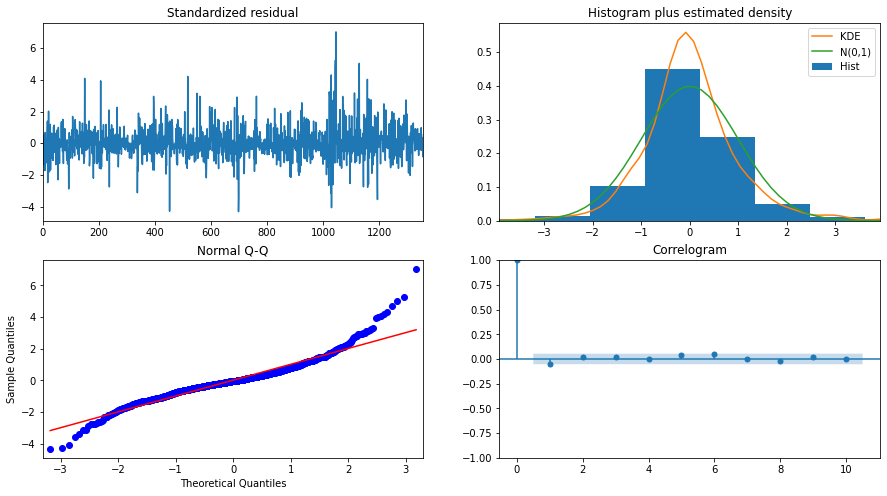

In [29]:
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

In [30]:
model = ARIMA(train_data, order=(3, 1, 2))
fitted = model.fit(disp=-1)
print(fitted.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 1359
Model:                 ARIMA(3, 1, 2)   Log Likelihood                3576.340
Method:                       css-mle   S.D. of innovations              0.017
Date:                Sat, 26 Feb 2022   AIC                          -7138.680
Time:                        16:51:22   BIC                          -7102.179
Sample:                             1   HQIC                         -7125.015
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0003      0.001      0.551      0.582      -0.001       0.001
ar.L1.D.Close    -0.1506      0.358     -0.421      0.674      -0.852       0.551
ar.L2.D.Close     0.6462      0.285     

In [31]:
fc, se, conf = fitted.forecast(152, alpha=0.05)

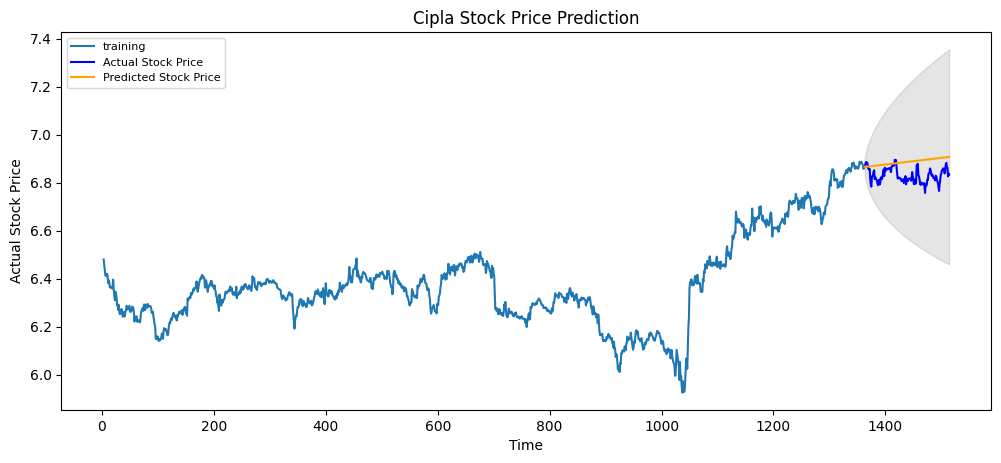

In [32]:
fc_series = pd.Series(fc, index=test_data.index)
lower_series = pd.Series(conf[:, 0], index=test_data.index)
upper_series = pd.Series(conf[:, 1], index=test_data.index)
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, color = 'blue', label='Actual Stock Price')
plt.plot(fc_series, color = 'orange',label='Predicted Stock Price')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.10)
plt.title('Cipla Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Actual Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [33]:
from sklearn.metrics import  mean_squared_error
rmse = mean_squared_error(test_data,fc_series,squared=False)
print(rmse)

0.06567381614064233


In [34]:
mape=np.mean(np.abs((test_data - fc_series) / test_data)) * 100
mape

0.8488580564822527

In [35]:
#3 MARUTI.NS.csv

In [38]:
df = pd.read_csv('MARUTI.NS.csv')
df

Date         Open         High          Low        Close  \
0     01-01-2016  4621.000000  4668.000000  4602.350098  4638.500000   
1     04-01-2016  4635.000000  4657.000000  4571.750000  4580.649902   
2     05-01-2016  4599.950195  4600.750000  4557.250000  4566.950195   
3     06-01-2016  4592.000000  4593.000000  4468.000000  4480.799805   
4     07-01-2016  4449.700195  4449.700195  4251.850098  4267.899902   
...          ...          ...          ...          ...          ...   
1510  11-02-2022  8738.000000  8865.000000  8673.299805  8737.150391   
1511  14-02-2022  8500.000000  8615.049805  8325.000000  8366.400391   
1512  15-02-2022  8410.000000  8664.250000  8356.500000  8622.700195   
1513  16-02-2022  8720.000000  8736.400391  8544.000000  8582.950195   
1514  17-02-2022  8575.000000  8658.299805  8525.000000  8552.450195   

        Adj Close   Volume  
0     4352.271973   243597  
1     4297.991699   405501  
2     4285.137207   509285  
3     4204.302734   593742  
4     4004.540283  1200069  
...           ...      ...  
1510  8737.150391   671572  
1511  8366.400391   995540  
1512  8622.700195   682766  
1513  8582.950195   422704  
1514  8552.450195   305313  

[1515 rows x 7 columns]

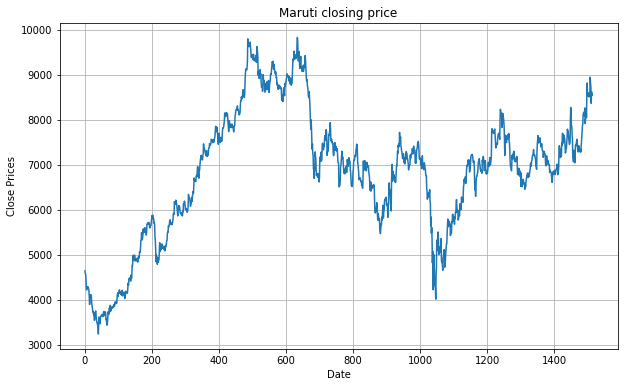

In [39]:
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Close Prices')
plt.plot(df['Close'])
plt.title('Maruti closing price')
plt.show()

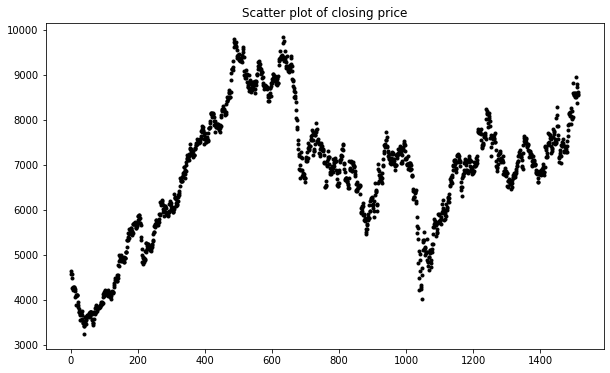

In [40]:
plt.figure(figsize=(10,6))
df_close = df['Close']
df_close.plot(style='k.')
plt.title('Scatter plot of closing price')
plt.show()

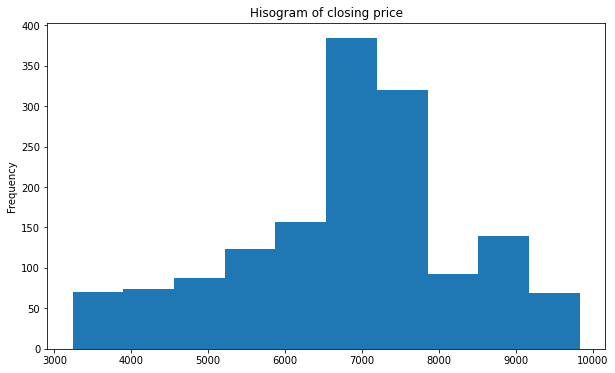

In [41]:
plt.figure(figsize=(10,6))
df_close = df['Close']
df_close.plot(style='k.',kind='hist')
plt.title('Hisogram of closing price')
plt.show()

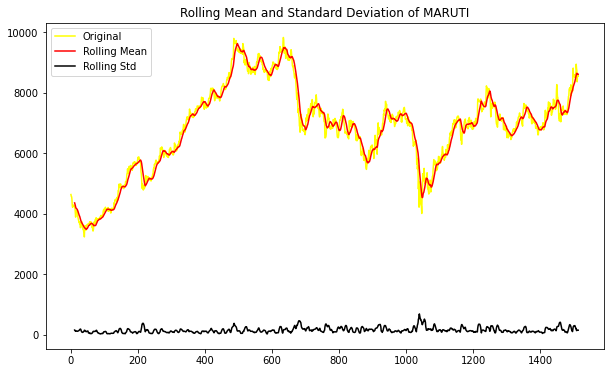

Results of dickey fuller test
Test Statistics                  -1.776535
p-value                           0.392172
No. of lags used                  0.000000
Number of observations used    1514.000000
critical value (1%)              -3.434677
critical value (5%)              -2.863451
critical value (10%)             -2.567787
dtype: float64


In [42]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='yellow',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation of MARUTI')
    plt.show(block=False)
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)

test_stationarity(df['Close'])

<Figure size 720x432 with 0 Axes>

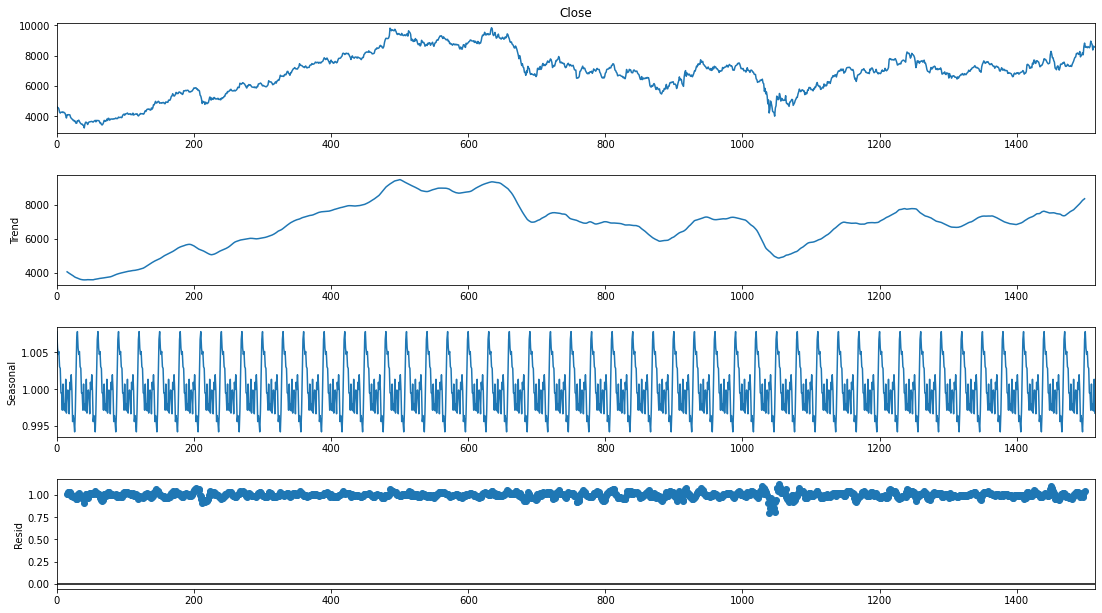

In [41]:
result = seasonal_decompose(df_close, model='multiplicative', freq = 30)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(16, 9)

No handles with labels found to put in legend.


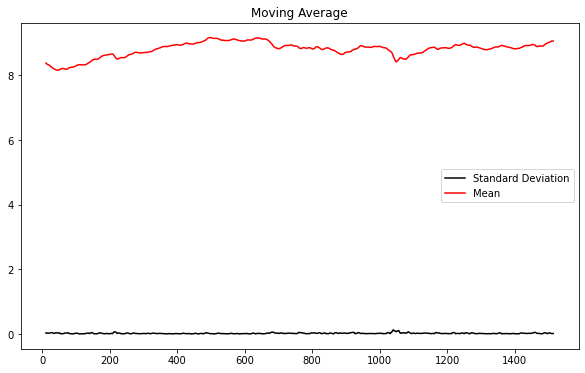

In [42]:
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
df_log = np.log(df['Close'])
moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend()
plt.show()

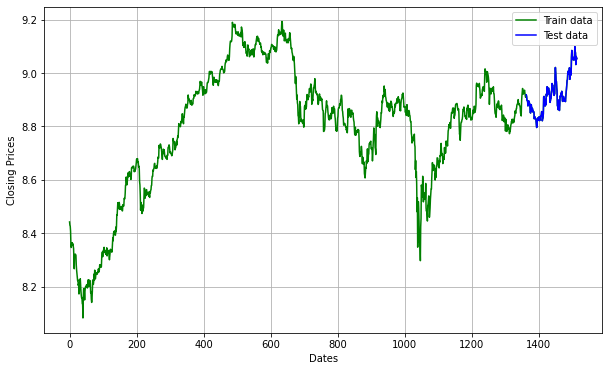

In [43]:
train_data, test_data = df_log[3:int(len(df_log)*0.9)], df_log[int(len(df_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_log, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()

In [44]:
model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
test='adf',       # use adftest to find optimal 'd'
max_p=3, max_q=3, # maximum p and q
m=1,              # frequency of series
d=None,           # let model determine 'd'
seasonal=False,   # No Seasonality
start_P=0, 
D=0, 
trace=True,
error_action='ignore',  
suppress_warnings=True, 
stepwise=True)
print(model_autoARIMA.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-6833.827, Time=0.75 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-6833.022, Time=0.61 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-6832.990, Time=2.29 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-6835.335, Time=0.62 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-6831.059, Time=1.14 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 5.437 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1360
Model:               SARIMAX(0, 1, 0)   Log Likelihood                3418.668
Date:                Sat, 26 Feb 2022   AIC                          -6835.335
Time:                        16:51:33   BIC                          -6830.121
Sample:                             0   HQIC                         -6833.383
                               - 1360                                  

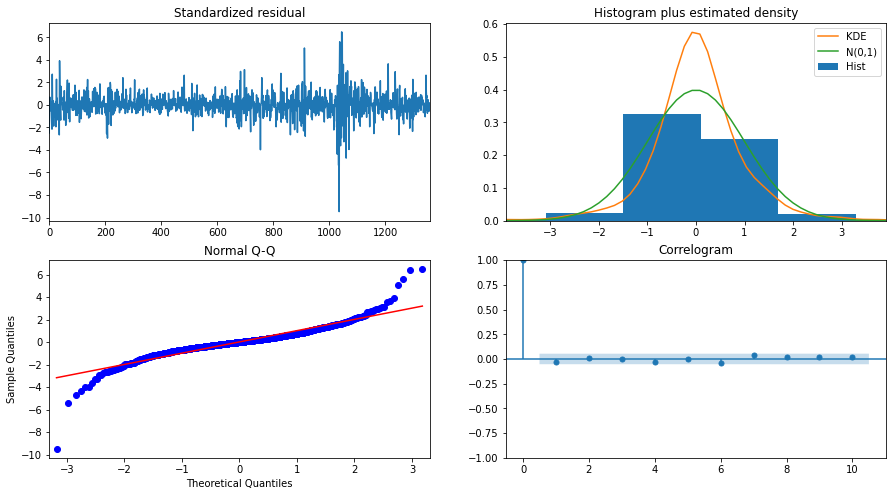

In [45]:
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

In [46]:
model = ARIMA(train_data, order=(3, 1, 2))
fitted = model.fit(disp=-1)
print(fitted.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 1359
Model:                 ARIMA(3, 1, 2)   Log Likelihood                3425.566
Method:                       css-mle   S.D. of innovations              0.019
Date:                Sat, 26 Feb 2022   AIC                          -6837.133
Time:                        16:51:43   BIC                          -6800.631
Sample:                             1   HQIC                         -6823.467
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0004      0.001      0.713      0.476      -0.001       0.001
ar.L1.D.Close     0.5092      0.027     18.675      0.000       0.456       0.563
ar.L2.D.Close    -0.9672      0.016    -

In [47]:
fc, se, conf = fitted.forecast(152, alpha=0.05)

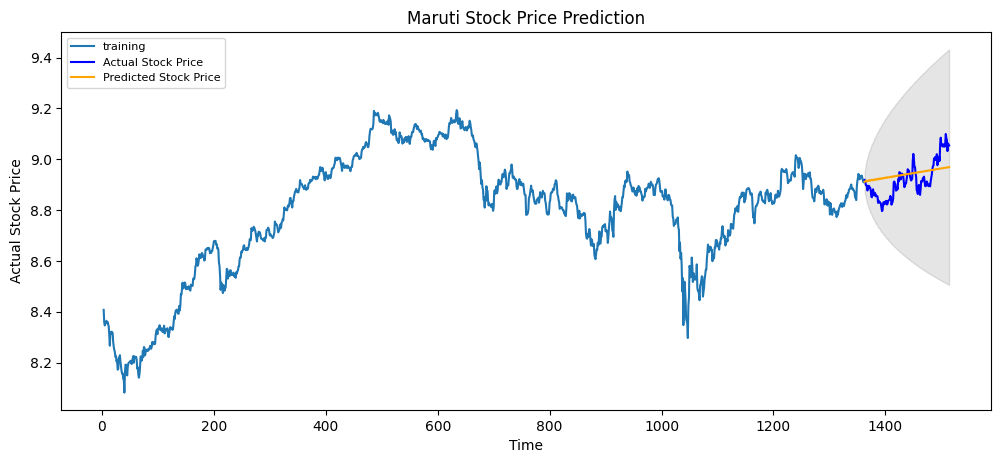

In [48]:
fc_series = pd.Series(fc, index=test_data.index)
lower_series = pd.Series(conf[:, 0], index=test_data.index)
upper_series = pd.Series(conf[:, 1], index=test_data.index)
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, color = 'blue', label='Actual Stock Price')
plt.plot(fc_series, color = 'orange',label='Predicted Stock Price')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.10)
plt.title('Maruti Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Actual Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [49]:
from sklearn.metrics import  mean_squared_error
rmse = mean_squared_error(test_data,fc_series,squared=False)
print(rmse)

0.0638685005385739


In [50]:
mape=np.mean(np.abs((test_data - fc_series) / test_data)) * 100
mape

0.60982500084237

In [51]:
#4 HINDUNILVR.NS.csv

In [43]:
df = pd.read_csv('HINDUNILVR.NS.csv')
df

Date         Open         High          Low        Close  \
0     2016-01-01   860.000000   862.000000   853.500000   856.549988   
1     2016-01-04   856.549988   868.700012   851.150024   859.000000   
2     2016-01-05   857.299988   859.049988   845.500000   847.950012   
3     2016-01-06   850.000000   850.000000   840.950012   843.049988   
4     2016-01-07   840.000000   840.950012   817.500000   820.250000   
...          ...          ...          ...          ...          ...   
1510  2022-02-11  2279.000000  2279.000000  2249.000000  2258.000000   
1511  2022-02-14  2220.000000  2236.250000  2207.000000  2228.550049   
1512  2022-02-15  2247.949951  2304.149902  2222.550049  2290.100098   
1513  2022-02-16  2290.100098  2303.750000  2275.000000  2286.500000   
1514  2022-02-17  2282.000000  2313.000000  2276.000000  2307.550049   

        Adj Close   Volume  
0      781.844116   230366  
1      784.080383   828876  
2      773.994080  1118709  
3      769.521606  2135092  
4      748.710022  1353969  
...           ...      ...  
1510  2258.000000  2100036  
1511  2228.550049  1661501  
1512  2290.100098  1533070  
1513  2286.500000   995668  
1514  2307.550049   869374  

[1515 rows x 7 columns]

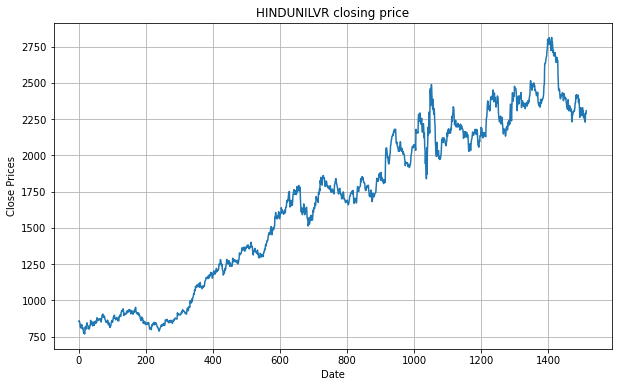

In [44]:
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Close Prices')
plt.plot(df['Close'])
plt.title('HINDUNILVR closing price')
plt.show()

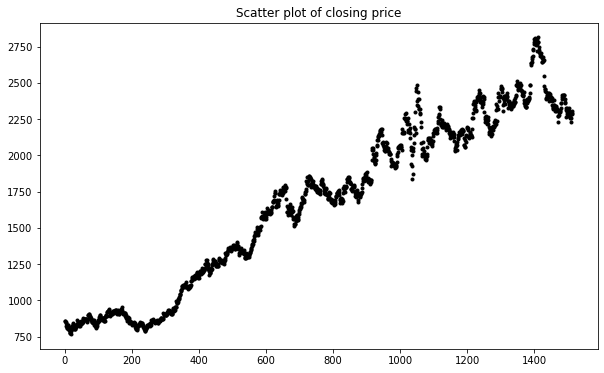

In [45]:
plt.figure(figsize=(10,6))
df_close = df['Close']
df_close.plot(style='k.')
plt.title('Scatter plot of closing price')
plt.show()

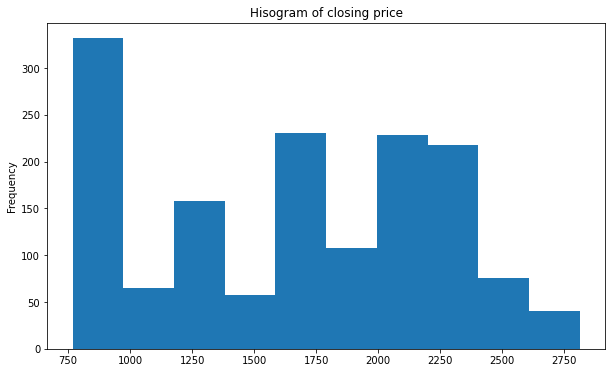

In [46]:
plt.figure(figsize=(10,6))
df_close = df['Close']
df_close.plot(style='k.',kind='hist')
plt.title('Hisogram of closing price')
plt.show()

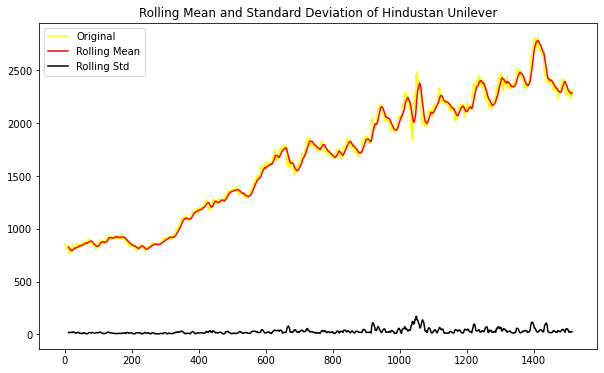

Results of dickey fuller test
Test Statistics                  -1.211951
p-value                           0.668434
No. of lags used                  7.000000
Number of observations used    1507.000000
critical value (1%)              -3.434697
critical value (5%)              -2.863460
critical value (10%)             -2.567792
dtype: float64


In [48]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='yellow',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation of Hindustan Unilever')
    plt.show(block=False)
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)

test_stationarity(df['Close'])

<Figure size 720x432 with 0 Axes>

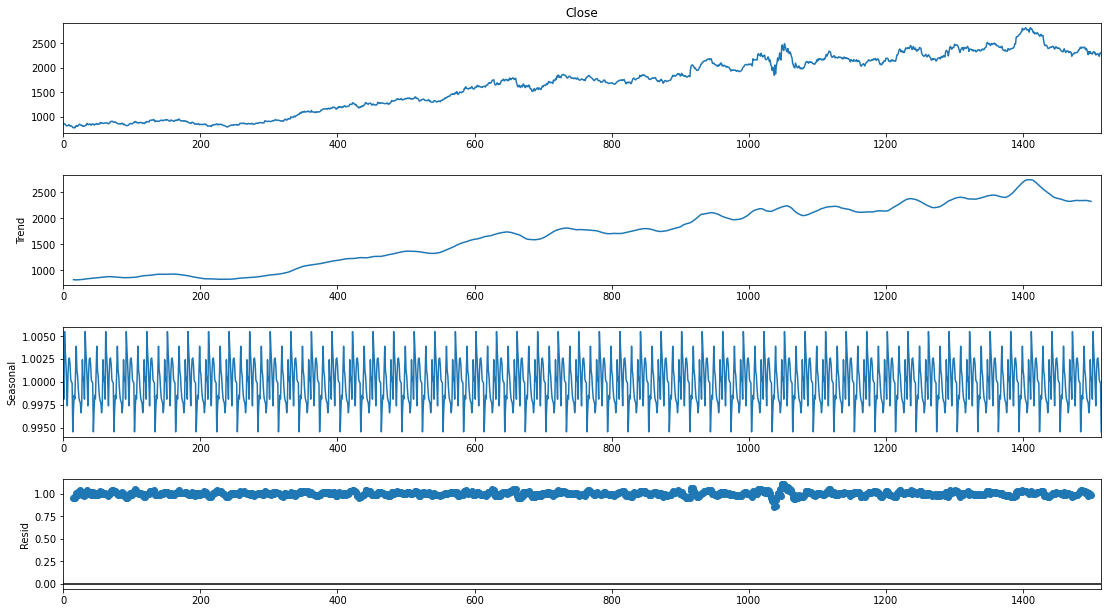

In [57]:
result = seasonal_decompose(df_close, model='multiplicative', freq = 30)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(16, 9)

No handles with labels found to put in legend.


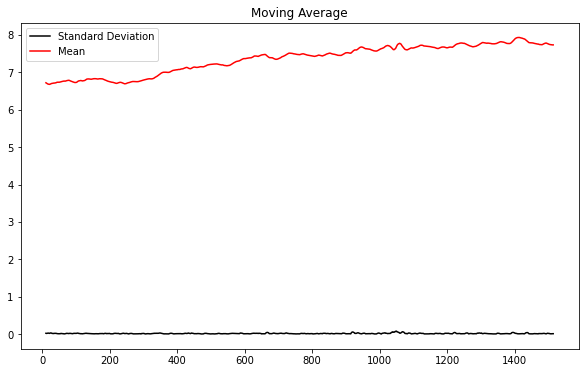

In [58]:
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
df_log = np.log(df['Close'])
moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend()
plt.show()

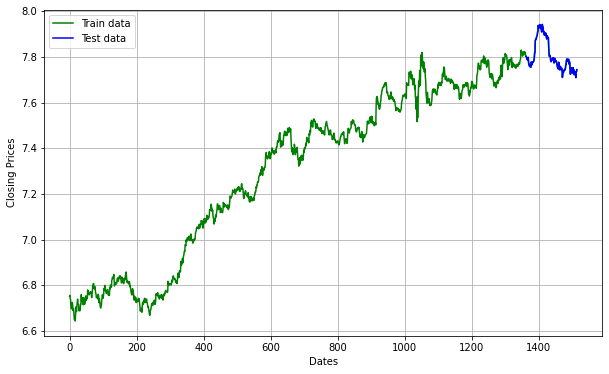

In [59]:
train_data, test_data = df_log[3:int(len(df_log)*0.9)], df_log[int(len(df_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_log, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()

In [60]:
model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
test='adf',       # use adftest to find optimal 'd'
max_p=3, max_q=3, # maximum p and q
m=1,              # frequency of series
d=None,           # let model determine 'd'
seasonal=False,   # No Seasonality
start_P=0, 
D=0, 
trace=True,
error_action='ignore',  
suppress_warnings=True, 
stepwise=True)
print(model_autoARIMA.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-7636.602, Time=0.50 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-7647.640, Time=0.41 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-7648.895, Time=0.73 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-7634.649, Time=0.65 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-7647.529, Time=0.56 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-7648.490, Time=0.65 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-7645.859, Time=1.41 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-7645.887, Time=0.39 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 5.323 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1360
Model:               SARIMAX(0, 1, 1)   Log Likelihood                3827.447
Date:                Sat, 26 Feb 2022   AIC                          -7648.895
Time:                       

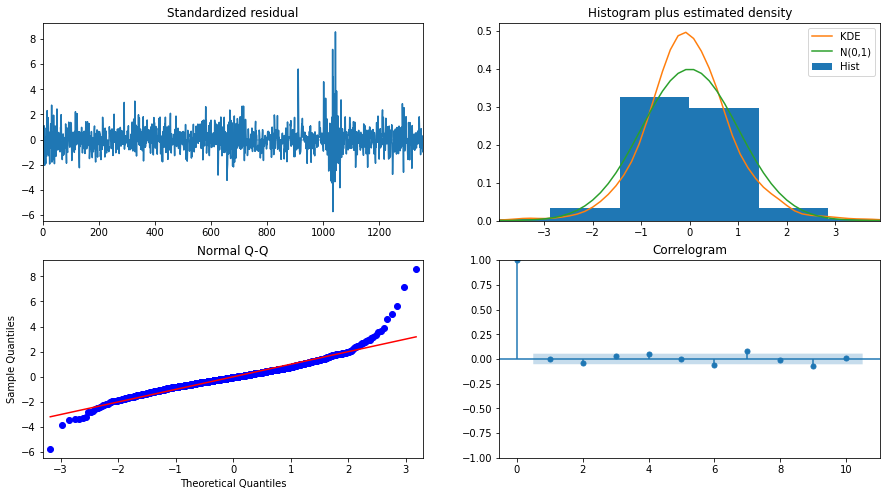

In [61]:
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

In [62]:
model = ARIMA(train_data, order=(3, 1, 2))
fitted = model.fit(disp=-1)
print(fitted.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 1359
Model:                 ARIMA(3, 1, 2)   Log Likelihood                3837.016
Method:                       css-mle   S.D. of innovations              0.014
Date:                Sat, 26 Feb 2022   AIC                          -7660.033
Time:                        16:52:04   BIC                          -7623.531
Sample:                             1   HQIC                         -7646.367
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0008      0.000      2.280      0.023       0.000       0.001
ar.L1.D.Close    -0.9079      0.051    -17.815      0.000      -1.008      -0.808
ar.L2.D.Close    -1.0059      0.051    -

In [63]:
fc, se, conf = fitted.forecast(152, alpha=0.05)

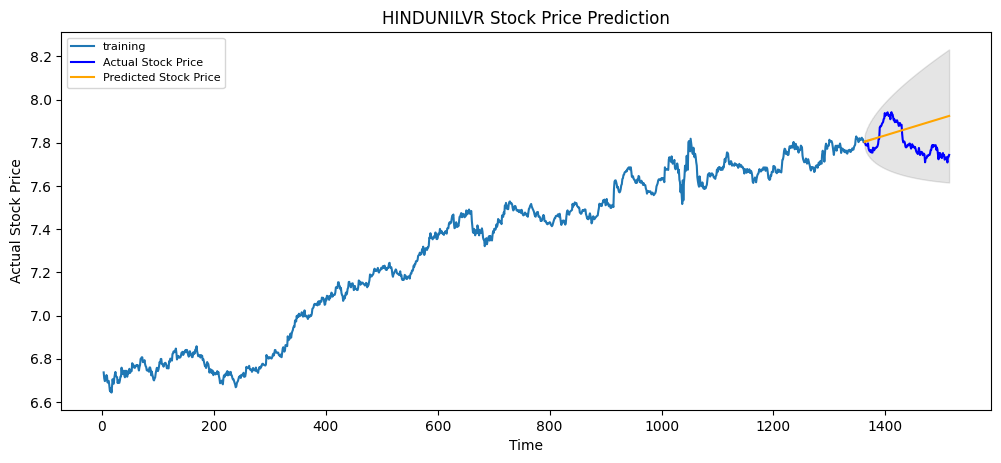

In [64]:
fc_series = pd.Series(fc, index=test_data.index)
lower_series = pd.Series(conf[:, 0], index=test_data.index)
upper_series = pd.Series(conf[:, 1], index=test_data.index)
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, color = 'blue', label='Actual Stock Price')
plt.plot(fc_series, color = 'orange',label='Predicted Stock Price')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.10)
plt.title('HINDUNILVR Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Actual Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [65]:
from sklearn.metrics import  mean_squared_error
rmse = mean_squared_error(test_data,fc_series,squared=False)
print(rmse)

0.10903155732326343


In [66]:
mape=np.mean(np.abs((test_data - fc_series) / test_data)) * 100
mape

1.229527697493302

In [67]:
#5 ICICIBANK.NS.csv

In [49]:
df = pd.read_csv('ICICIBANK.NS.csv')
df

Date        Open        High         Low       Close   Adj Close  \
0     2016-01-01  237.545456  239.636368  234.545456  239.090912  227.072784   
1     2016-01-04  237.272720  237.590912  231.500000  232.318176  220.640518   
2     2016-01-05  232.954544  234.090912  228.818176  233.363632  221.633408   
3     2016-01-06  232.181824  233.409088  226.545456  227.363632  215.934998   
4     2016-01-07  224.000000  225.181824  221.000000  224.318176  213.042603   
...          ...         ...         ...         ...         ...         ...   
1510  2022-02-11  796.849976  797.400024  787.900024  790.799988  790.799988   
1511  2022-02-14  772.000000  773.950012  751.150024  753.700012  753.700012   
1512  2022-02-15  752.950012  778.000000  743.200012  776.049988  776.049988   
1513  2022-02-16  775.700012  777.549988  760.400024  764.049988  764.049988   
1514  2022-02-17  766.500000  767.250000  746.299988  750.349976  750.349976   

        Volume  
0      5998096  
1      9435792  
2      8966977  
3     17416181  
4     18240712  
...        ...  
1510  13138408  
1511  16170656  
1512  18880659  
1513  10549784  
1514  16683808  

[1515 rows x 7 columns]

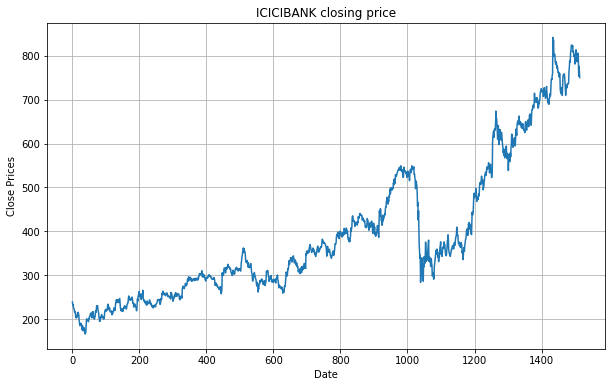

In [50]:
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Close Prices')
plt.plot(df['Close'])
plt.title('ICICIBANK closing price')
plt.show()

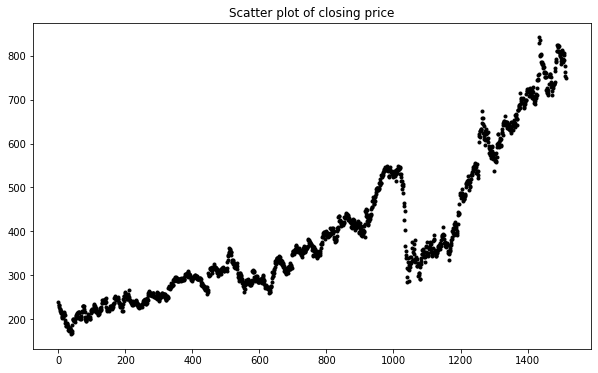

In [51]:
plt.figure(figsize=(10,6))
df_close = df['Close']
df_close.plot(style='k.')
plt.title('Scatter plot of closing price')
plt.show()

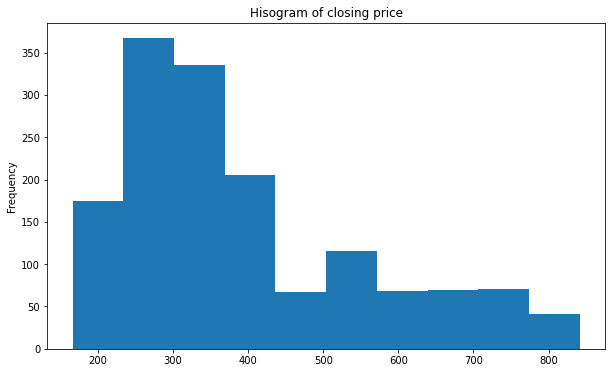

In [52]:
plt.figure(figsize=(10,6))
df_close = df['Close']
df_close.plot(style='k.',kind='hist')
plt.title('Hisogram of closing price')
plt.show()

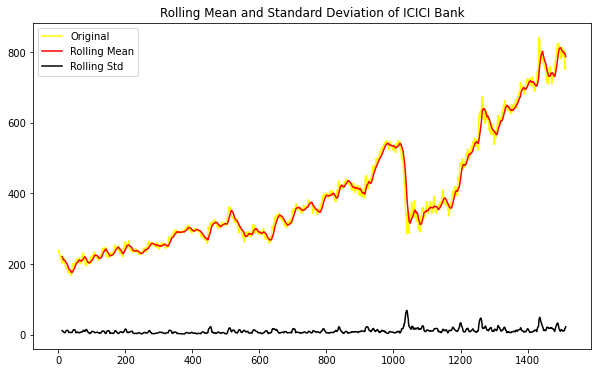

Results of dickey fuller test
Test Statistics                  -0.229224
p-value                           0.934947
No. of lags used                  6.000000
Number of observations used    1508.000000
critical value (1%)              -3.434694
critical value (5%)              -2.863459
critical value (10%)             -2.567791
dtype: float64


In [54]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='yellow',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation of ICICI Bank')
    plt.show(block=False)
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)

test_stationarity(df['Close'])

<Figure size 720x432 with 0 Axes>

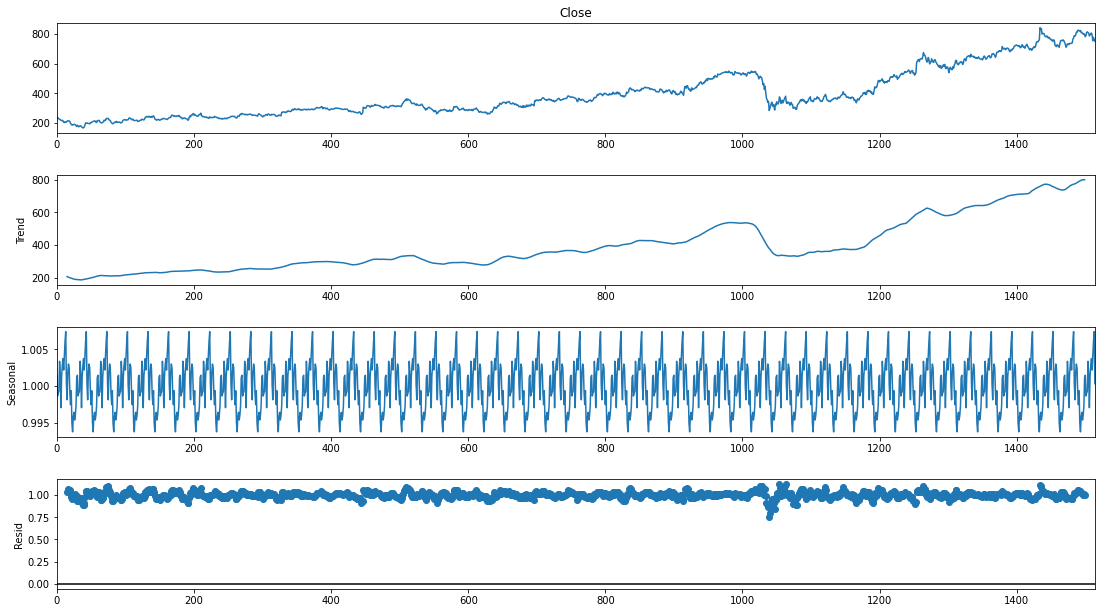

In [73]:
result = seasonal_decompose(df_close, model='multiplicative', freq = 30)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(16, 9)

No handles with labels found to put in legend.


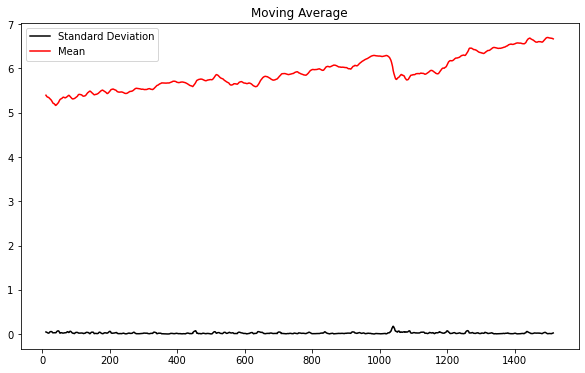

In [74]:
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
df_log = np.log(df['Close'])
moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend()
plt.show()

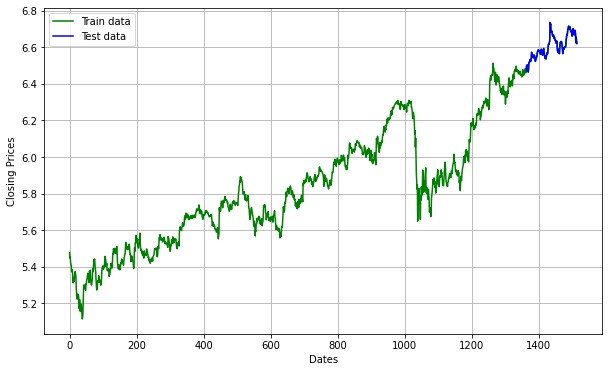

In [75]:
train_data, test_data = df_log[3:int(len(df_log)*0.9)], df_log[int(len(df_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_log, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()

In [76]:
model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
test='adf',       # use adftest to find optimal 'd'
max_p=3, max_q=3, # maximum p and q
m=1,              # frequency of series
d=None,           # let model determine 'd'
seasonal=False,   # No Seasonality
start_P=0, 
D=0, 
trace=True,
error_action='ignore',  
suppress_warnings=True, 
stepwise=True)
print(model_autoARIMA.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-6388.734, Time=0.58 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-6387.299, Time=0.38 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-6387.317, Time=0.39 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-6389.256, Time=0.30 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-6385.678, Time=3.03 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 4.703 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1360
Model:               SARIMAX(0, 1, 0)   Log Likelihood                3195.628
Date:                Sat, 26 Feb 2022   AIC                          -6389.256
Time:                        16:52:15   BIC                          -6384.041
Sample:                             0   HQIC                         -6387.304
                               - 1360                                  

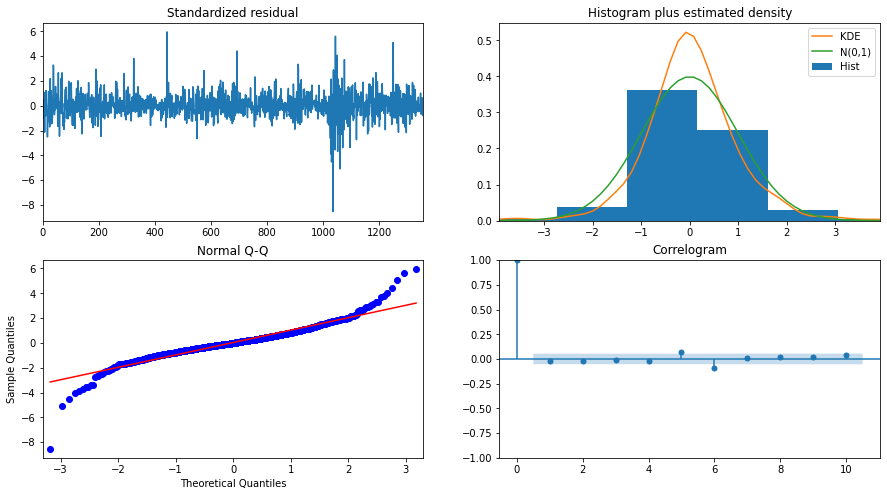

In [77]:
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

In [78]:
model = ARIMA(train_data, order=(3, 1, 2))
fitted = model.fit(disp=-1)
print(fitted.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 1359
Model:                 ARIMA(3, 1, 2)   Log Likelihood                3201.429
Method:                       css-mle   S.D. of innovations              0.023
Date:                Sat, 26 Feb 2022   AIC                          -6388.857
Time:                        16:52:21   BIC                          -6352.356
Sample:                             1   HQIC                         -6375.192
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0008      0.001      1.274      0.203      -0.000       0.002
ar.L1.D.Close     0.0024      0.055      0.043      0.965      -0.106       0.111
ar.L2.D.Close    -0.9292      0.062    -

In [79]:
fc, se, conf = fitted.forecast(152, alpha=0.05)

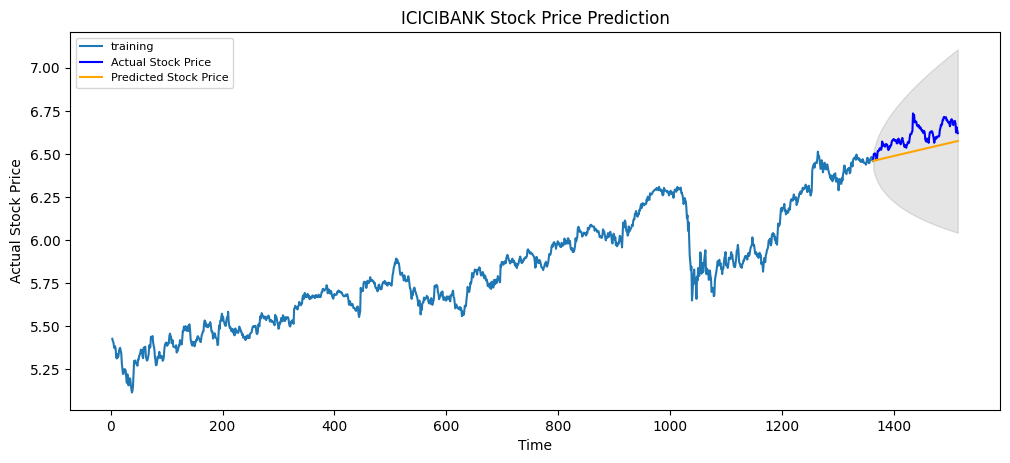

In [80]:
fc_series = pd.Series(fc, index=test_data.index)
lower_series = pd.Series(conf[:, 0], index=test_data.index)
upper_series = pd.Series(conf[:, 1], index=test_data.index)
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, color = 'blue', label='Actual Stock Price')
plt.plot(fc_series, color = 'orange',label='Predicted Stock Price')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.10)
plt.title('ICICIBANK Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Actual Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [81]:
from sklearn.metrics import  mean_squared_error
rmse = mean_squared_error(test_data,fc_series,squared=False)
print(rmse)

0.0960464633262156


In [82]:
mape=np.mean(np.abs((test_data - fc_series) / test_data)) * 100
mape

1.3101093717949364

In [83]:
#6 NESTLEIND.NS.csv

In [55]:
df = pd.read_csv('NESTLEIND.NS.csv')
df

Date          Open          High           Low         Close  \
0     2016-01-01   5820.049805   5850.000000   5775.000000   5785.149902   
1     2016-01-04   5814.000000   5827.000000   5652.000000   5669.799805   
2     2016-01-05   5739.000000   5739.000000   5650.000000   5662.399902   
3     2016-01-06   5666.100098   5729.549805   5655.000000   5719.500000   
4     2016-01-07   5729.950195   5729.950195   5621.399902   5638.950195   
...          ...           ...           ...           ...           ...   
1510  2022-02-11  18135.000000  18135.000000  17620.000000  17815.199219   
1511  2022-02-14  17716.000000  17800.250000  17429.800781  17670.250000   
1512  2022-02-15  17670.250000  18323.250000  17571.449219  18187.099609   
1513  2022-02-16  18167.000000  18397.400391  18033.500000  18223.800781   
1514  2022-02-17  18400.000000  18400.000000  17960.150391  18126.000000   

         Adj Close  Volume  
0      5280.468750   12085  
1      5175.180664   35426  
2      5168.427246   27112  
3      5220.545898   55372  
4      5147.023438   22220  
...            ...     ...  
1510  17815.199219   95980  
1511  17670.250000   42917  
1512  18187.099609   50170  
1513  18223.800781   40410  
1514  18126.000000  113840  

[1515 rows x 7 columns]

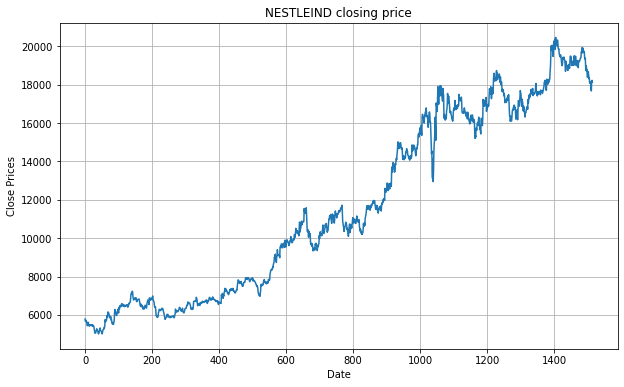

In [56]:
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Close Prices')
plt.plot(df['Close'])
plt.title('NESTLEIND closing price')
plt.show()

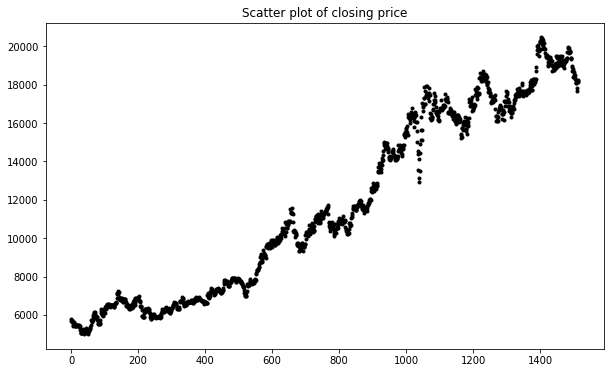

In [57]:
plt.figure(figsize=(10,6))
df_close = df['Close']
df_close.plot(style='k.')
plt.title('Scatter plot of closing price')
plt.show()

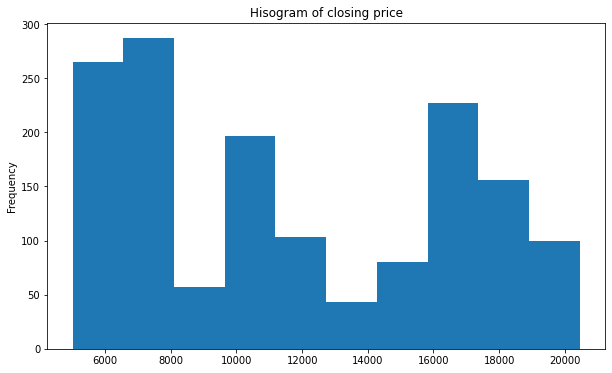

In [58]:
plt.figure(figsize=(10,6))
df_close = df['Close']
df_close.plot(style='k.',kind='hist')
plt.title('Hisogram of closing price')
plt.show()

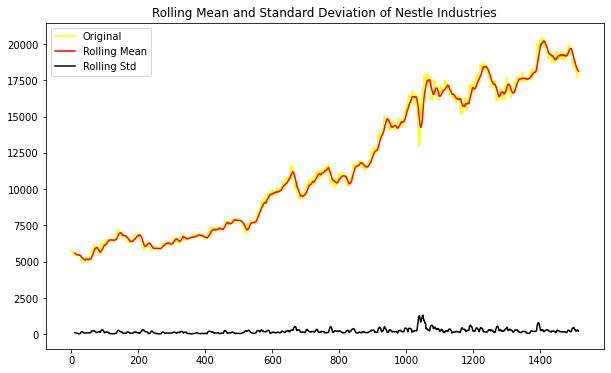

Results of dickey fuller test
Test Statistics                  -0.532761
p-value                           0.885463
No. of lags used                 24.000000
Number of observations used    1490.000000
critical value (1%)              -3.434746
critical value (5%)              -2.863482
critical value (10%)             -2.567804
dtype: float64


In [59]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='yellow',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation of Nestle Industries')
    plt.show(block=False)
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)

test_stationarity(df['Close'])

<Figure size 720x432 with 0 Axes>

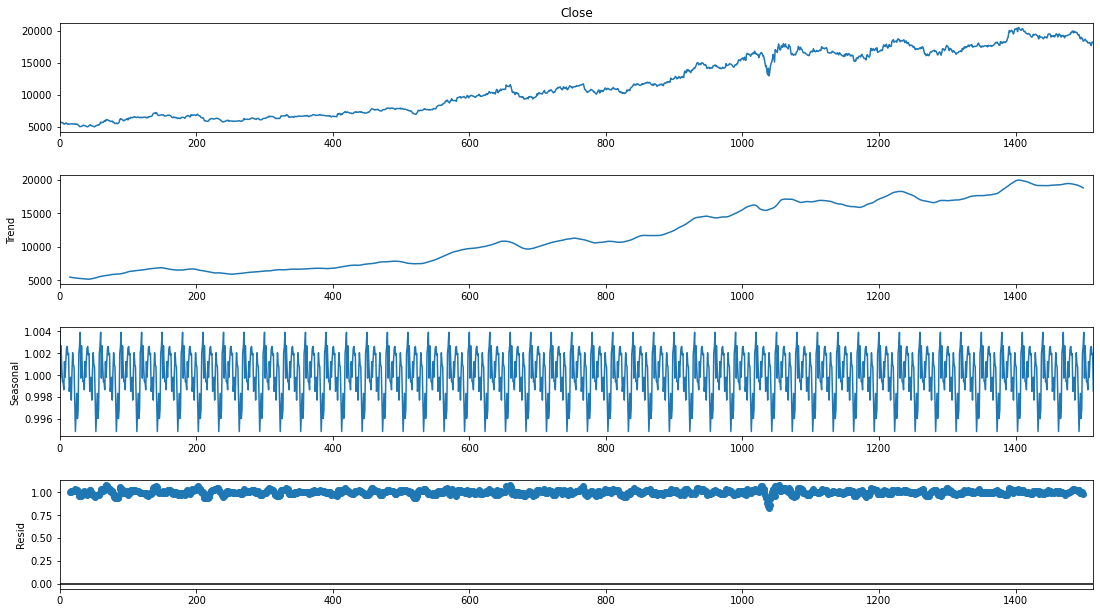

In [89]:
result = seasonal_decompose(df_close, model='multiplicative', freq = 30)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(16, 9)

No handles with labels found to put in legend.


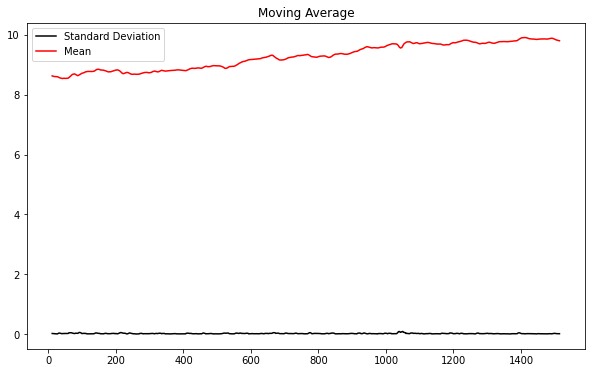

In [90]:
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
df_log = np.log(df['Close'])
moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend()
plt.show()

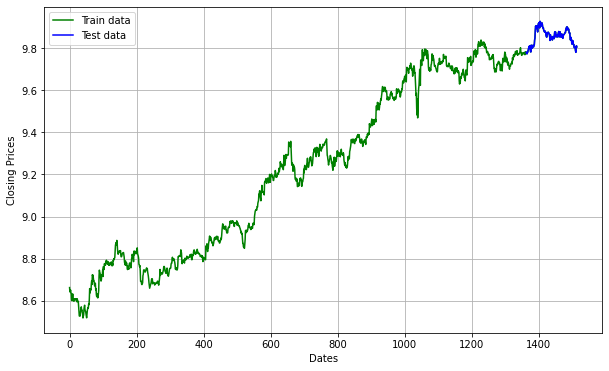

In [91]:
train_data, test_data = df_log[3:int(len(df_log)*0.9)], df_log[int(len(df_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_log, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()

In [92]:
model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
test='adf',       # use adftest to find optimal 'd'
max_p=3, max_q=3, # maximum p and q
m=1,              # frequency of series
d=None,           # let model determine 'd'
seasonal=False,   # No Seasonality
start_P=0, 
D=0, 
trace=True,
error_action='ignore',  
suppress_warnings=True, 
stepwise=True)
print(model_autoARIMA.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-7485.347, Time=0.79 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-7485.518, Time=0.62 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-7485.702, Time=0.92 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-7483.410, Time=0.33 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-7482.369, Time=0.56 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-7485.459, Time=0.58 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-7486.992, Time=0.71 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-7485.177, Time=0.85 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-7487.186, Time=1.90 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-7488.864, Time=0.73 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=-7486.836, Time=0.78 sec

Best model:  ARIMA(0,1,3)(0,0,0)[0] intercept
Total fit time: 8.804 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:       

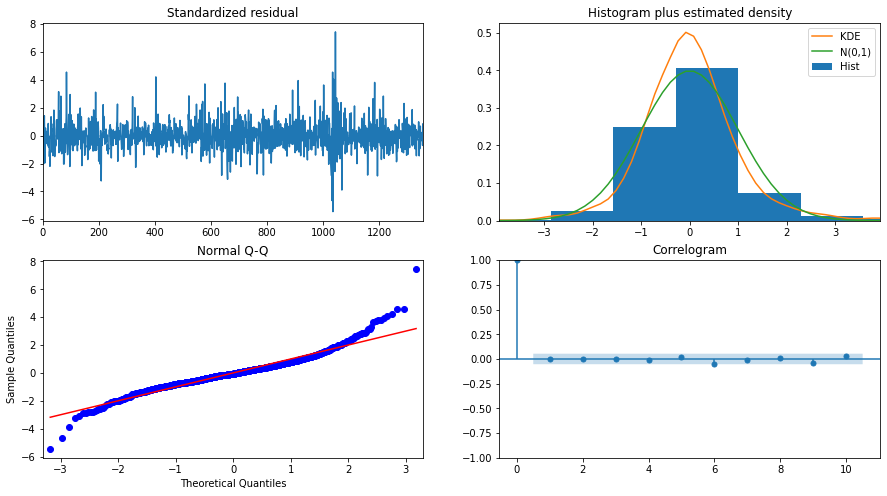

In [93]:
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

In [94]:
model = ARIMA(train_data, order=(3, 1, 2))
fitted = model.fit(disp=-1)
print(fitted.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 1359
Model:                 ARIMA(3, 1, 2)   Log Likelihood                3749.716
Method:                       css-mle   S.D. of innovations              0.015
Date:                Sat, 26 Feb 2022   AIC                          -7485.431
Time:                        16:52:41   BIC                          -7448.930
Sample:                             1   HQIC                         -7471.766
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0008      0.000      2.048      0.041    3.58e-05       0.002
ar.L1.D.Close    -0.2266      0.453     -0.501      0.617      -1.114       0.660
ar.L2.D.Close     0.2008      0.323     

In [95]:
fc, se, conf = fitted.forecast(152, alpha=0.05)

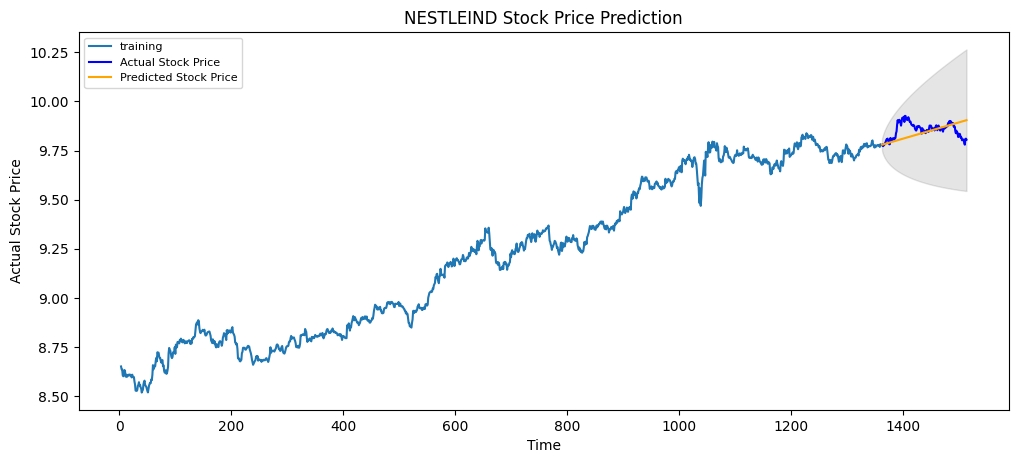

In [96]:
fc_series = pd.Series(fc, index=test_data.index)
lower_series = pd.Series(conf[:, 0], index=test_data.index)
upper_series = pd.Series(conf[:, 1], index=test_data.index)
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, color = 'blue', label='Actual Stock Price')
plt.plot(fc_series, color = 'orange',label='Predicted Stock Price')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.10)
plt.title('NESTLEIND Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Actual Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [97]:
from sklearn.metrics import  mean_squared_error
rmse = mean_squared_error(test_data,fc_series,squared=False)
print(rmse)

0.05193941294125232


In [98]:
mape=np.mean(np.abs((test_data - fc_series) / test_data)) * 100
mape

0.3769951077773716

In [99]:
#7 TCS 

In [60]:
df = pd.read_csv('TCS.NS.csv')
df

Date         Open         High          Low        Close  \
0     2016-01-01  1219.500000  1219.500000  1206.125000  1208.199951   
1     2016-01-04  1205.074951  1207.000000  1183.025024  1184.800049   
2     2016-01-05  1192.500000  1193.300049  1170.500000  1174.474976   
3     2016-01-06  1175.099976  1193.074951  1175.099976  1190.800049   
4     2016-01-07  1185.000000  1191.449951  1180.000000  1185.625000   
...          ...          ...          ...          ...          ...   
1510  2022-02-11  3752.500000  3752.500000  3690.000000  3694.949951   
1511  2022-02-14  3724.000000  3793.250000  3710.000000  3733.750000   
1512  2022-02-15  3786.000000  3835.000000  3748.000000  3817.800049   
1513  2022-02-16  3844.000000  3854.100098  3806.000000  3813.100098   
1514  2022-02-17  3825.000000  3835.000000  3779.000000  3784.199951   

        Adj Close   Volume  
0     1075.699341   712262  
1     1054.865723  1870184  
2     1045.672974  2678020  
3     1060.207886  2653228  
4     1055.600464  3199580  
...           ...      ...  
1510  3694.949951  3851488  
1511  3733.750000  5951745  
1512  3817.800049  3931683  
1513  3813.100098  3256906  
1514  3784.199951  3134372  

[1515 rows x 7 columns]

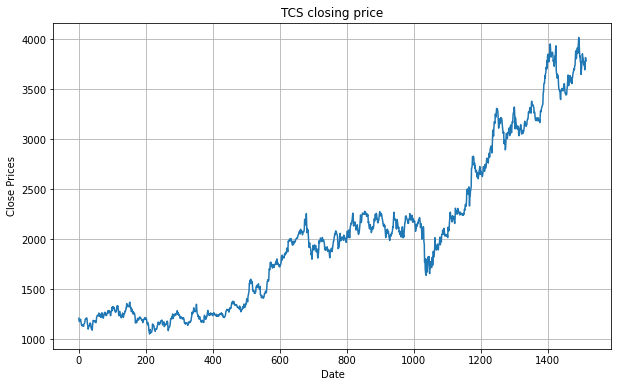

In [61]:
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Close Prices')
plt.plot(df['Close'])
plt.title('TCS closing price')
plt.show()

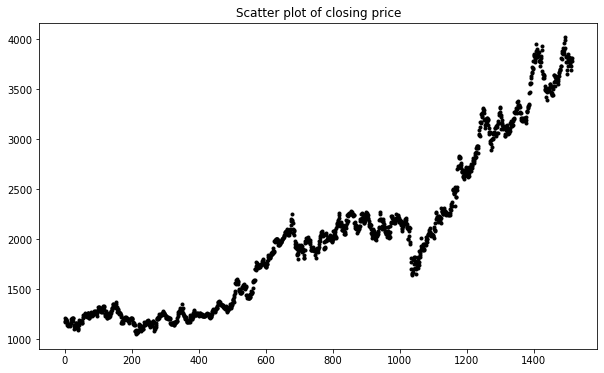

In [62]:
plt.figure(figsize=(10,6))
df_close = df['Close']
df_close.plot(style='k.')
plt.title('Scatter plot of closing price')
plt.show()

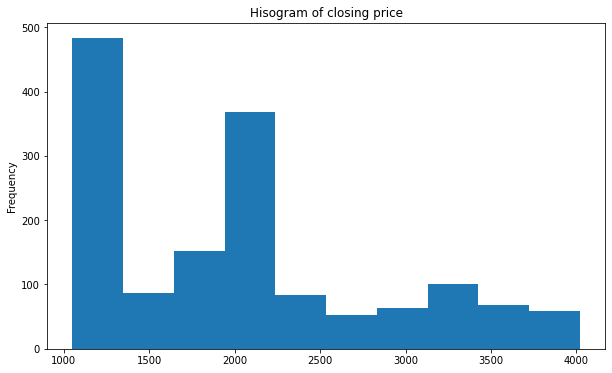

In [63]:
plt.figure(figsize=(10,6))
df_close = df['Close']
df_close.plot(style='k.',kind='hist')
plt.title('Hisogram of closing price')
plt.show()

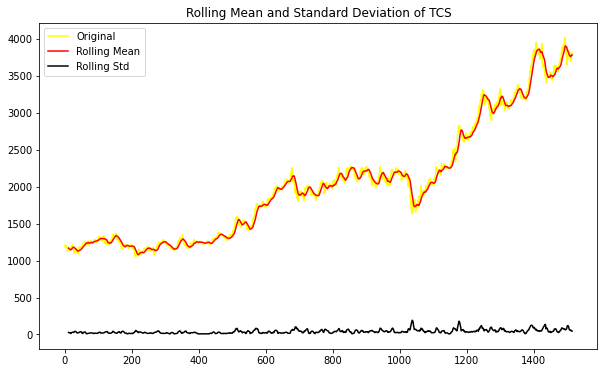

Results of dickey fuller test
Test Statistics                   0.453322
p-value                           0.983383
No. of lags used                  2.000000
Number of observations used    1512.000000
critical value (1%)              -3.434682
critical value (5%)              -2.863453
critical value (10%)             -2.567789
dtype: float64


In [64]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='yellow',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation of TCS')
    plt.show(block=False)
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)

test_stationarity(df['Close'])

<Figure size 720x432 with 0 Axes>

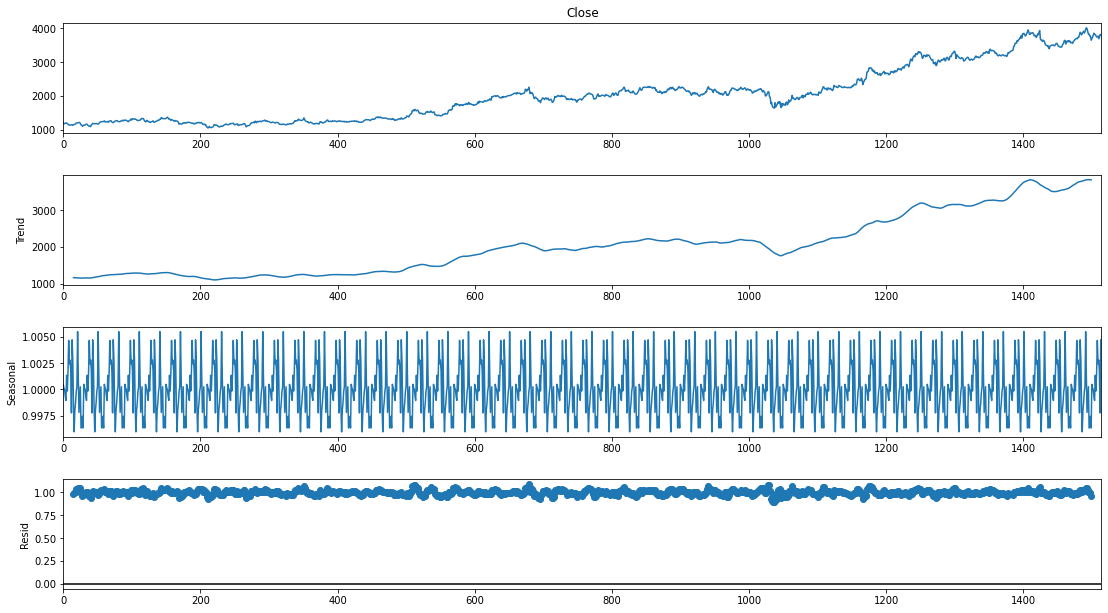

In [105]:
result = seasonal_decompose(df_close, model='multiplicative', freq = 30)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(16, 9)

No handles with labels found to put in legend.


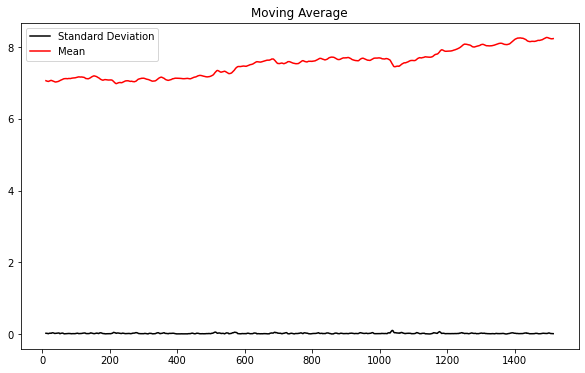

In [106]:
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
df_log = np.log(df['Close'])
moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend()
plt.show()

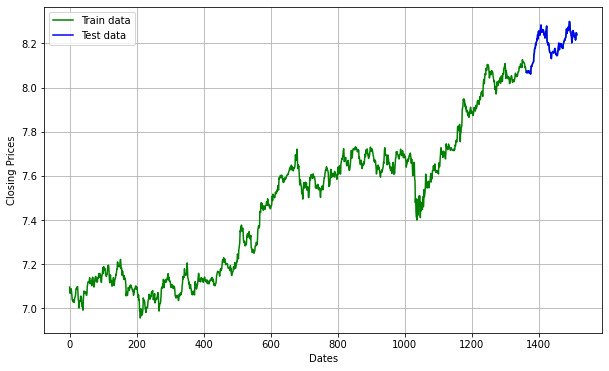

In [107]:
train_data, test_data = df_log[3:int(len(df_log)*0.9)], df_log[int(len(df_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_log, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()

In [108]:
model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
test='adf',       # use adftest to find optimal 'd'
max_p=3, max_q=3, # maximum p and q
m=1,              # frequency of series
d=None,           # let model determine 'd'
seasonal=False,   # No Seasonality
start_P=0, 
D=0, 
trace=True,
error_action='ignore',  
suppress_warnings=True, 
stepwise=True)
print(model_autoARIMA.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-7357.063, Time=0.72 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-7356.195, Time=0.37 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-7356.254, Time=0.37 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-7356.287, Time=0.65 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-7354.738, Time=1.21 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 3.346 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1360
Model:               SARIMAX(0, 1, 0)   Log Likelihood                3680.532
Date:                Sat, 26 Feb 2022   AIC                          -7357.063
Time:                        16:52:50   BIC                          -7346.634
Sample:                             0   HQIC                         -7353.159
                               - 1360                                  

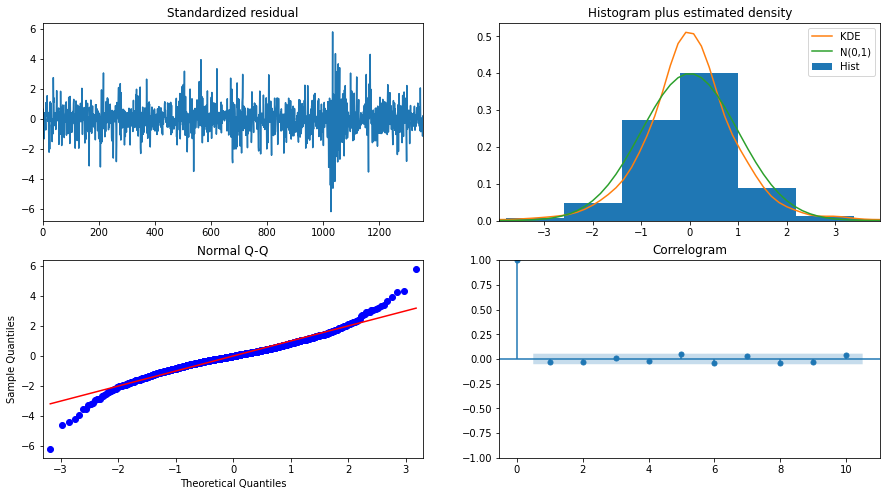

In [109]:
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

In [110]:
model = ARIMA(train_data, order=(3, 1, 2))
fitted = model.fit(disp=-1)
print(fitted.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 1359
Model:                 ARIMA(3, 1, 2)   Log Likelihood                3684.429
Method:                       css-mle   S.D. of innovations              0.016
Date:                Sat, 26 Feb 2022   AIC                          -7354.858
Time:                        16:52:57   BIC                          -7318.357
Sample:                             1   HQIC                         -7341.193
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0007      0.000      2.406      0.016       0.000       0.001
ar.L1.D.Close     0.1561      0.125      1.246      0.213      -0.089       0.401
ar.L2.D.Close     0.7126      0.121     

In [111]:
fc, se, conf = fitted.forecast(152, alpha=0.05)

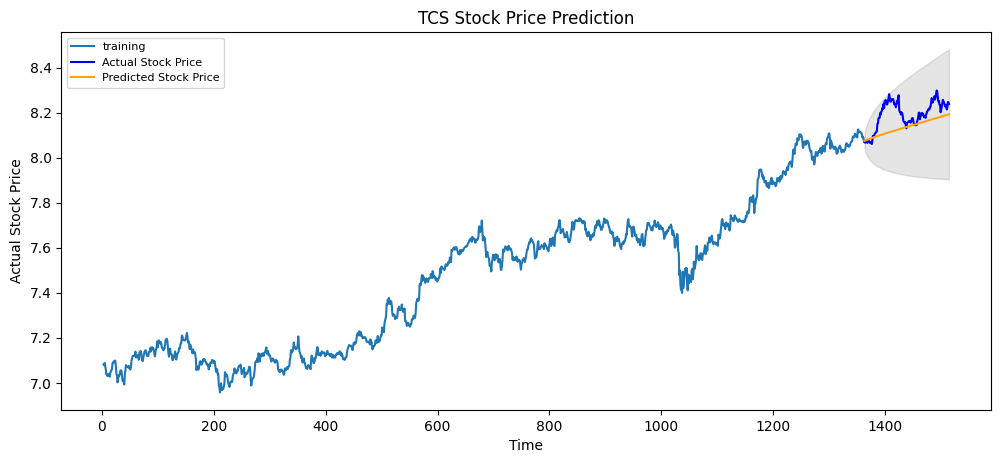

In [112]:
fc_series = pd.Series(fc, index=test_data.index)
lower_series = pd.Series(conf[:, 0], index=test_data.index)
upper_series = pd.Series(conf[:, 1], index=test_data.index)
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, color = 'blue', label='Actual Stock Price')
plt.plot(fc_series, color = 'orange',label='Predicted Stock Price')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.10)
plt.title('TCS Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Actual Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [113]:
from sklearn.metrics import  mean_squared_error
rmse = mean_squared_error(test_data,fc_series,squared=False)
print(rmse)

0.07544090656966648


In [114]:
mape=np.mean(np.abs((test_data - fc_series) / test_data)) * 100
mape

0.7237386262760231

In [115]:
#8 'RAMCOCEM.NS.csv

In [65]:
df = pd.read_csv('RAMCOCEM.NS.csv')
df

Date        Open        High         Low       Close   Adj Close  \
0     2016-01-01  391.649994  402.000000  382.350006  389.799988  379.417603   
1     2016-01-04  393.000000  393.600006  376.100006  389.200012  378.833557   
2     2016-01-05  383.250000  400.000000  383.250000  398.350006  387.739868   
3     2016-01-06  399.950012  404.000000  388.350006  391.000000  380.585602   
4     2016-01-07  389.000000  392.100006  386.000000  390.000000  379.612213   
...          ...         ...         ...         ...         ...         ...   
1510  2022-02-11  885.000000  886.900024  868.250000  872.900024  872.900024   
1511  2022-02-14  855.000000  862.349976  833.049988  836.500000  836.500000   
1512  2022-02-15  840.000000  888.000000  827.000000  881.250000  881.250000   
1513  2022-02-16  881.000000  882.299988  855.099976  861.349976  861.349976   
1514  2022-02-17  865.900024  868.000000  851.400024  859.650024  859.650024   

      Volume  
0      60581  
1      79920  
2     118475  
3     525730  
4     410722  
...      ...  
1510  107865  
1511  155690  
1512  393474  
1513  662795  
1514  261514  

[1515 rows x 7 columns]

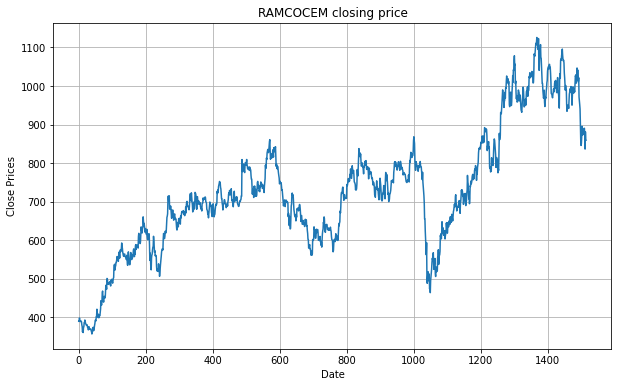

In [66]:
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Close Prices')
plt.plot(df['Close'])
plt.title('RAMCOCEM closing price')
plt.show()

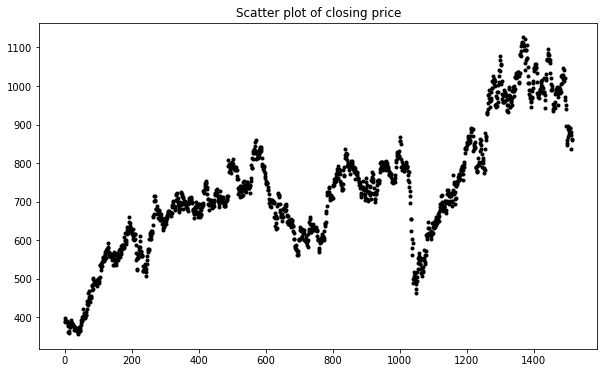

In [67]:
plt.figure(figsize=(10,6))
df_close = df['Close']
df_close.plot(style='k.')
plt.title('Scatter plot of closing price')
plt.show()

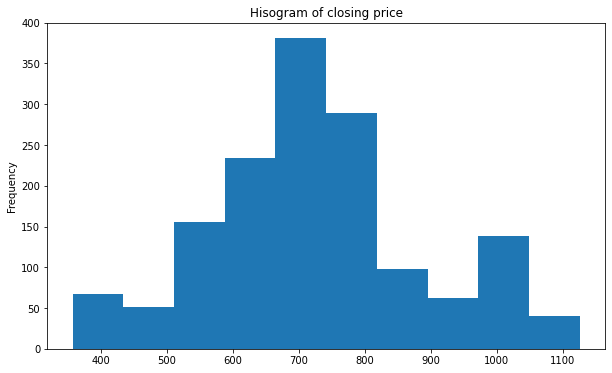

In [68]:
plt.figure(figsize=(10,6))
df_close = df['Close']
df_close.plot(style='k.',kind='hist')
plt.title('Hisogram of closing price')
plt.show()

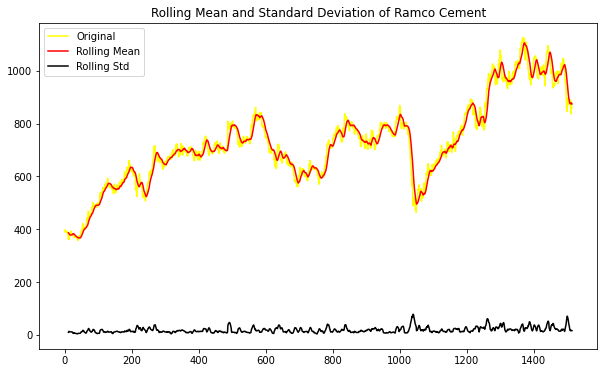

Results of dickey fuller test
Test Statistics                  -2.210937
p-value                           0.202300
No. of lags used                  0.000000
Number of observations used    1514.000000
critical value (1%)              -3.434677
critical value (5%)              -2.863451
critical value (10%)             -2.567787
dtype: float64


In [69]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='yellow',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation of Ramco Cement')
    plt.show(block=False)
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)

test_stationarity(df['Close'])

<Figure size 720x432 with 0 Axes>

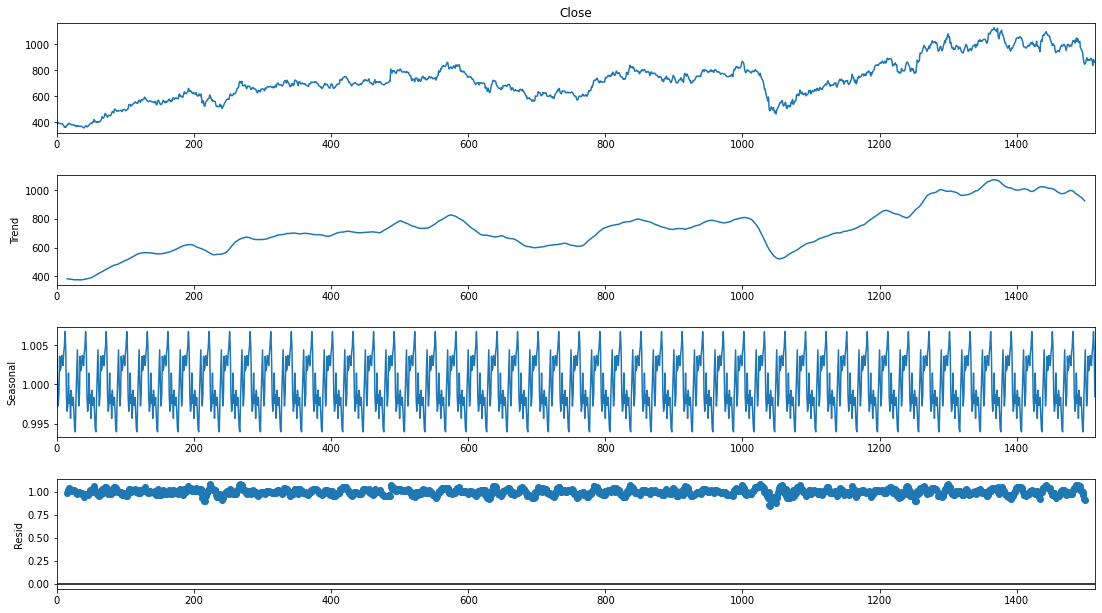

In [121]:
result = seasonal_decompose(df_close, model='multiplicative', freq = 30)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(16, 9)

No handles with labels found to put in legend.


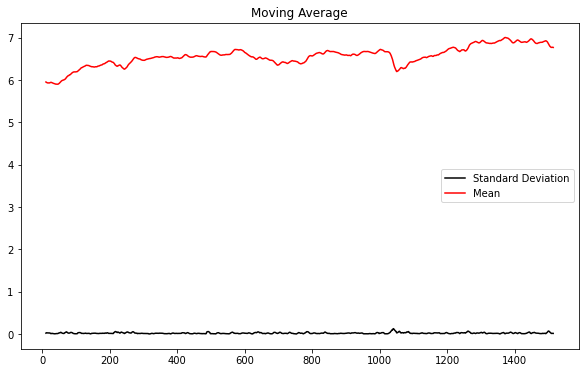

In [122]:
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
df_log = np.log(df['Close'])
moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend()
plt.show()

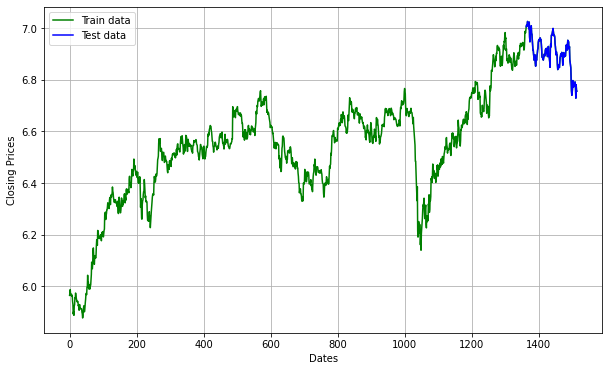

In [123]:
train_data, test_data = df_log[3:int(len(df_log)*0.9)], df_log[int(len(df_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_log, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()

In [124]:
model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
test='adf',       # use adftest to find optimal 'd'
max_p=4, max_q=4, # maximum p and q
m=1,              # frequency of series
d=None,           # let model determine 'd'
seasonal=False,   # No Seasonality
start_P=0, 
D=0, 
trace=True,
error_action='ignore',  
suppress_warnings=True, 
stepwise=True)
print(model_autoARIMA.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-6867.801, Time=0.48 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-6866.035, Time=1.99 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-6866.043, Time=0.42 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-6867.728, Time=0.23 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-6861.834, Time=1.55 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 4.683 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1360
Model:               SARIMAX(0, 1, 0)   Log Likelihood                3435.900
Date:                Sat, 26 Feb 2022   AIC                          -6867.801
Time:                        16:53:09   BIC                          -6857.372
Sample:                             0   HQIC                         -6863.896
                               - 1360                                  

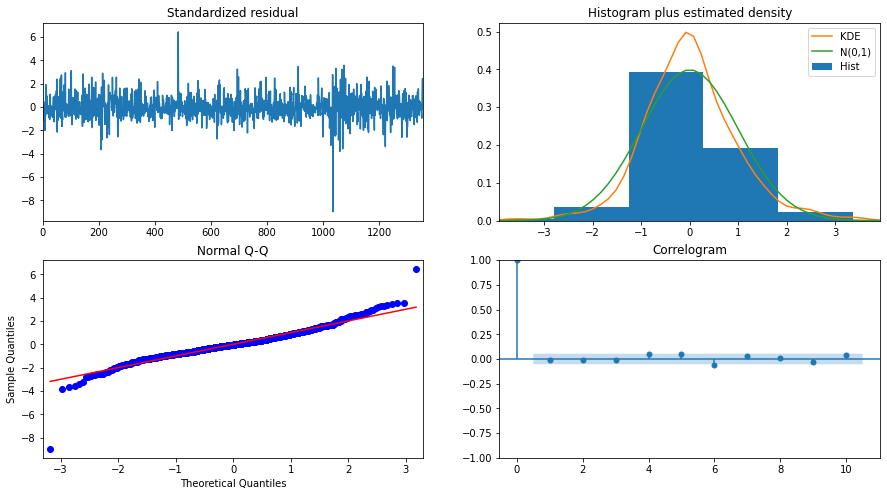

In [125]:
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

In [126]:
model = ARIMA(train_data, order=(3, 1, 2))
fitted = model.fit(disp=-1)
print(fitted.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 1359
Model:                 ARIMA(3, 1, 2)   Log Likelihood                3442.184
Method:                       css-mle   S.D. of innovations              0.019
Date:                Sat, 26 Feb 2022   AIC                          -6870.368
Time:                        16:53:15   BIC                          -6833.866
Sample:                             1   HQIC                         -6856.703
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0008      0.001      1.480      0.139      -0.000       0.002
ar.L1.D.Close    -0.4714      0.031    -15.037      0.000      -0.533      -0.410
ar.L2.D.Close    -0.9937      0.027    -

In [127]:
fc, se, conf = fitted.forecast(152, alpha=0.05)

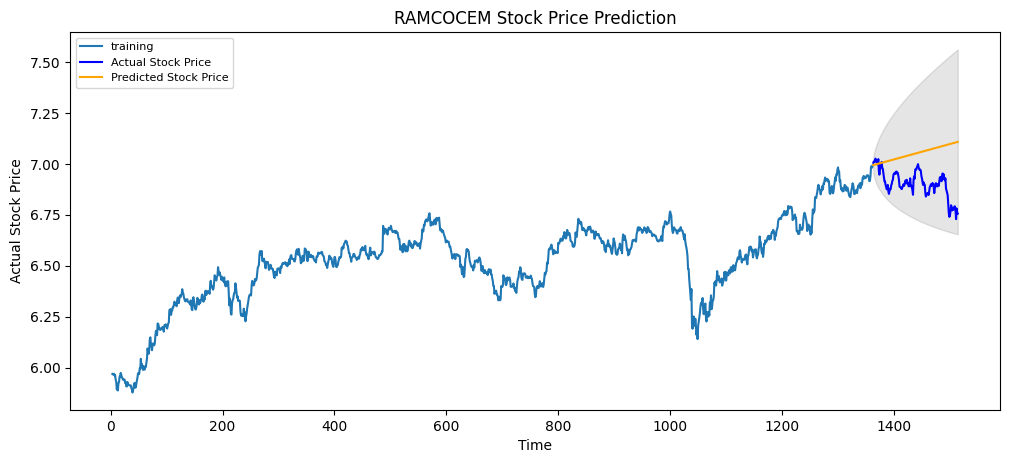

In [128]:
fc_series = pd.Series(fc, index=test_data.index)
lower_series = pd.Series(conf[:, 0], index=test_data.index)
upper_series = pd.Series(conf[:, 1], index=test_data.index)
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, color = 'blue', label='Actual Stock Price')
plt.plot(fc_series, color = 'orange',label='Predicted Stock Price')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.10)
plt.title('RAMCOCEM Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Actual Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [129]:
from sklearn.metrics import  mean_squared_error
rmse = mean_squared_error(test_data,fc_series,squared=False)
print(rmse)

0.17336612708270177


In [130]:
mape=np.mean(np.abs((test_data - fc_series) / test_data)) * 100
mape

2.180935305822216

In [131]:
#9 NIFTYBEES.NS.csv

In [70]:
df = pd.read_csv('NIFTYBEES.NS.csv')
df

Date        Open        High         Low       Close   Adj Close  \
0     2016-01-01   80.199997   80.750000   80.000000   80.505997   80.505997   
1     2016-01-04   80.294998   80.349998   78.900002   79.030998   79.030998   
2     2016-01-05   79.387001   79.394997   78.794998   78.981003   78.981003   
3     2016-01-06   78.980003   79.087997   78.370003   78.515999   78.515999   
4     2016-01-07   78.200996   78.300003   76.724998   76.891998   76.891998   
...          ...         ...         ...         ...         ...         ...   
1510  2022-02-11  192.500000  192.500000  187.000000  188.000000  188.000000   
1511  2022-02-14  187.500000  187.500000  182.300003  182.589996  182.589996   
1512  2022-02-15  185.000000  187.880005  182.589996  187.589996  187.589996   
1513  2022-02-16  190.000000  190.000000  186.449997  187.139999  187.139999   
1514  2022-02-17  190.000000  190.000000  186.169998  186.929993  186.929993   

       Volume  
0      273470  
1      403970  
2      347970  
3      486200  
4     1563600  
...       ...  
1510  2152018  
1511  7366629  
1512  2687788  
1513  2043037  
1514  1415247  

[1515 rows x 7 columns]

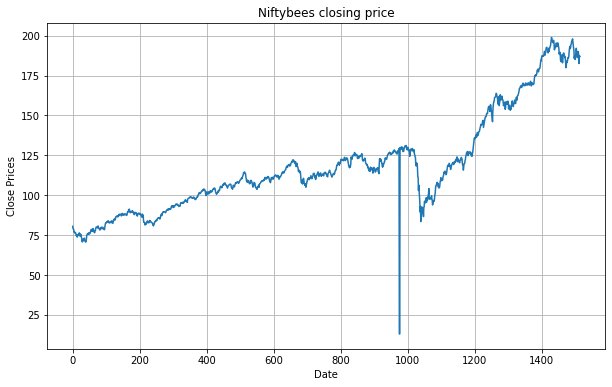

In [71]:
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Close Prices')
plt.plot(df['Close'])
plt.title('Niftybees closing price')
plt.show()

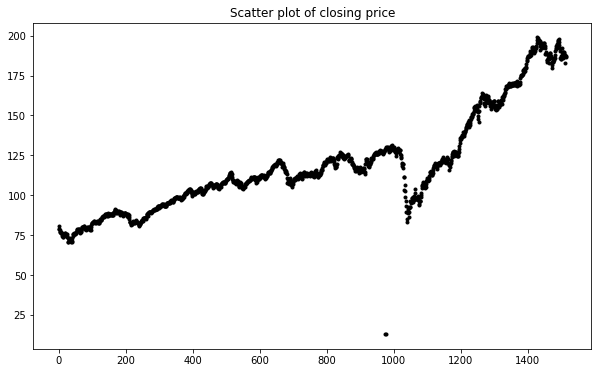

In [72]:
plt.figure(figsize=(10,6))
df_close = df['Close']
df_close.plot(style='k.')
plt.title('Scatter plot of closing price')
plt.show()

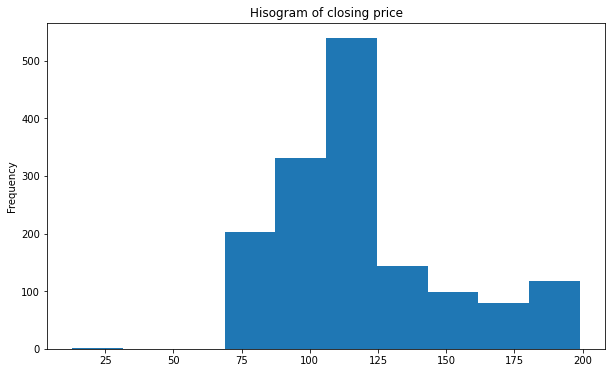

In [73]:
plt.figure(figsize=(10,6))
df_close = df['Close']
df_close.plot(style='k.',kind='hist')
plt.title('Hisogram of closing price')
plt.show()

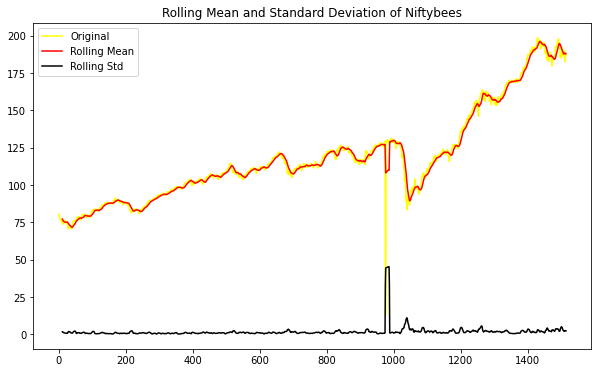

Results of dickey fuller test
Test Statistics                  -0.068644
p-value                           0.952474
No. of lags used                 10.000000
Number of observations used    1504.000000
critical value (1%)              -3.434705
critical value (5%)              -2.863464
critical value (10%)             -2.567794
dtype: float64


In [74]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='yellow',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation of Niftybees')
    plt.show(block=False)
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)

test_stationarity(df['Close'])

<Figure size 720x432 with 0 Axes>

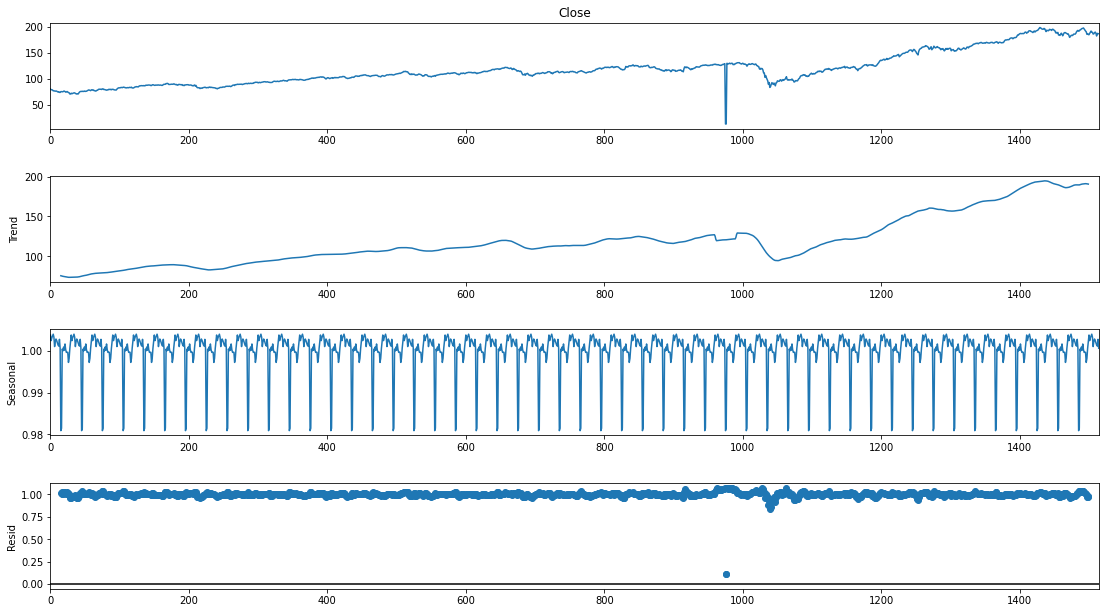

In [137]:
result = seasonal_decompose(df_close, model='multiplicative', freq = 30)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(16, 9)

No handles with labels found to put in legend.


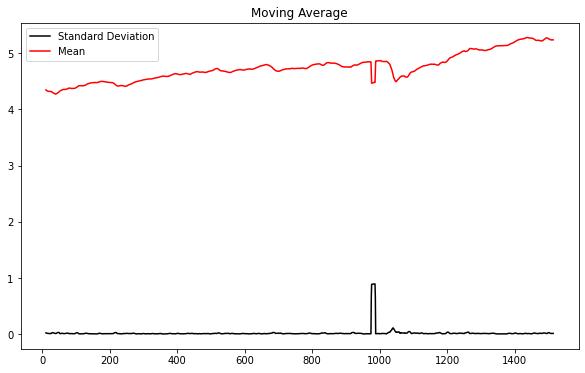

In [138]:
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
df_log = np.log(df['Close'])
moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend()
plt.show()

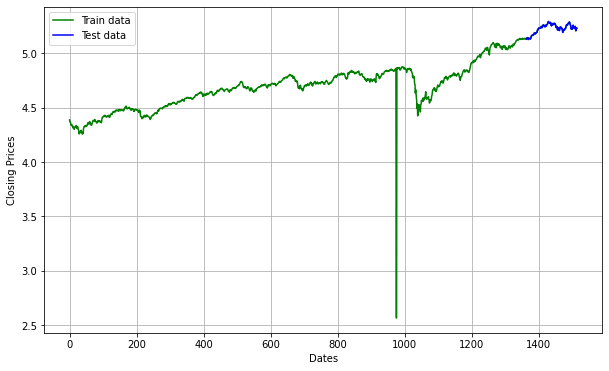

In [139]:
train_data, test_data = df_log[3:int(len(df_log)*0.9)], df_log[int(len(df_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_log, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()

In [140]:
model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
test='adf',       # use adftest to find optimal 'd'
max_p=3, max_q=3, # maximum p and q
m=1,              # frequency of series
d=None,           # let model determine 'd'
seasonal=False,   # No Seasonality
start_P=0, 
D=0, 
trace=True,
error_action='ignore',  
suppress_warnings=True, 
stepwise=True)
print(model_autoARIMA.summary())

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8068.612, Time=0.05 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.30 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=1.30 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-2714.697, Time=0.54 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=3.50 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-3443.569, Time=2.79 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=4473.929, Time=0.77 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=3.96 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=-3438.635, Time=3.24 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=3027.237, Time=1.19 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=inf, Time=6.30 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-3415.253, Time=4.27 sec

Best model:  ARIMA(1,0,2)(0,0,0)[0]          
Total fit time: 28.248 seconds
                               SARIMAX Results                                
Dep. Variable:               

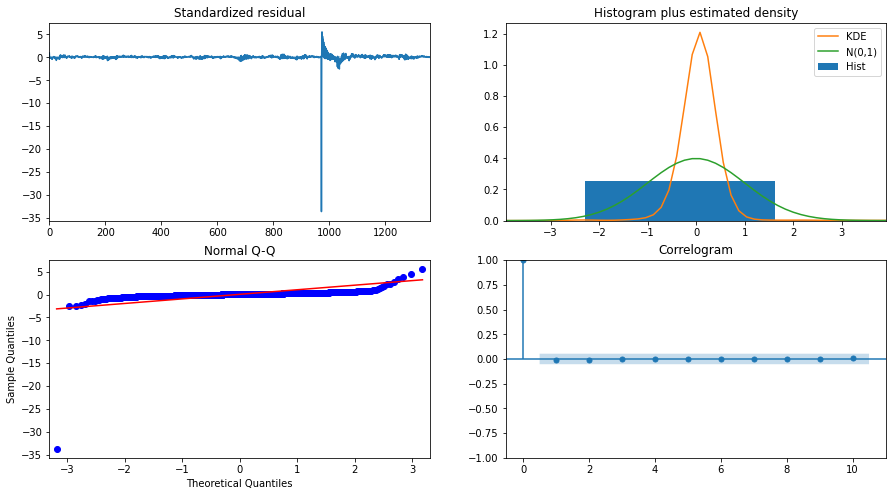

In [141]:
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

In [142]:
model = ARIMA(train_data, order=(3, 1, 2))
fitted = model.fit(disp=-1)
print(fitted.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 1359
Model:                 ARIMA(3, 1, 2)   Log Likelihood                1730.494
Method:                       css-mle   S.D. of innovations              0.068
Date:                Sat, 26 Feb 2022   AIC                          -3446.988
Time:                        16:53:54   BIC                          -3410.486
Sample:                             1   HQIC                         -3433.323
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0006      0.000      1.876      0.061   -2.67e-05       0.001
ar.L1.D.Close    -0.0092      0.035     -0.261      0.794      -0.078       0.060
ar.L2.D.Close    -0.0011      0.033     

In [143]:
fc, se, conf = fitted.forecast(152, alpha=0.05)

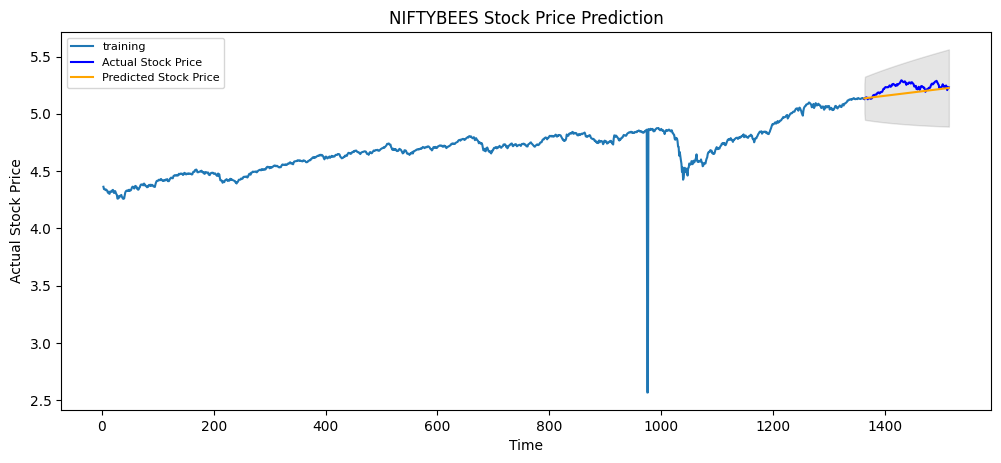

In [144]:
fc_series = pd.Series(fc, index=test_data.index)
lower_series = pd.Series(conf[:, 0], index=test_data.index)
upper_series = pd.Series(conf[:, 1], index=test_data.index)
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, color = 'blue', label='Actual Stock Price')
plt.plot(fc_series, color = 'orange',label='Predicted Stock Price')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.10)
plt.title('NIFTYBEES Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Actual Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [145]:
from sklearn.metrics import  mean_squared_error
rmse = mean_squared_error(test_data,fc_series,squared=False)
print(rmse)

0.058234488703245796


In [146]:
mape=np.mean(np.abs((test_data - fc_series) / test_data)) * 100
mape

0.9160138941986515

In [147]:
#10 BANKBEES.NS.csv

In [75]:
df = pd.read_csv('BANKBEES.NS.csv')
df

Date        Open        High         Low       Close   Adj Close  \
0     2016-01-01  170.199997  171.800003  169.259995  171.347000  171.347000   
1     2016-01-04  170.350006  170.399994  167.014999  167.294998  167.294998   
2     2016-01-05  167.500000  167.750000  166.251007  166.813995  166.813995   
3     2016-01-06  166.800003  167.199997  165.100006  165.123993  165.123993   
4     2016-01-07  165.000000  165.000000  161.600006  161.979996  161.979996   
...          ...         ...         ...         ...         ...         ...   
1510  2022-02-11  392.000000  392.700012  386.510010  388.000000  388.000000   
1511  2022-02-14  382.000000  387.000000  371.239990  372.200012  372.200012   
1512  2022-02-15  375.489990  385.000000  369.769989  384.279999  384.279999   
1513  2022-02-16  383.600006  386.700012  380.500000  381.549988  381.549988   
1514  2022-02-17  385.000000  385.000000  377.010010  377.929993  377.929993   

       Volume  
0       75270  
1       67670  
2       35430  
3       94420  
4     1622460  
...       ...  
1510   771155  
1511  1808412  
1512   831057  
1513   621344  
1514   540092  

[1515 rows x 7 columns]

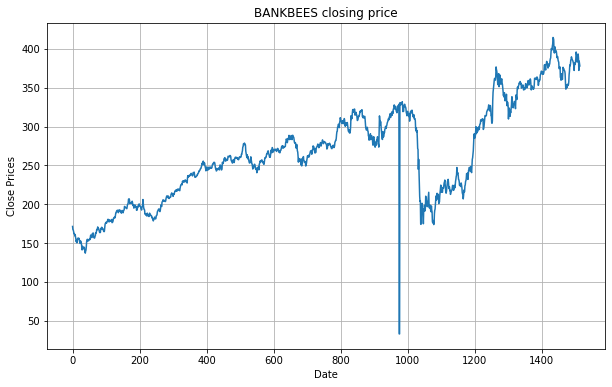

In [76]:
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Close Prices')
plt.plot(df['Close'])
plt.title('BANKBEES closing price')
plt.show()

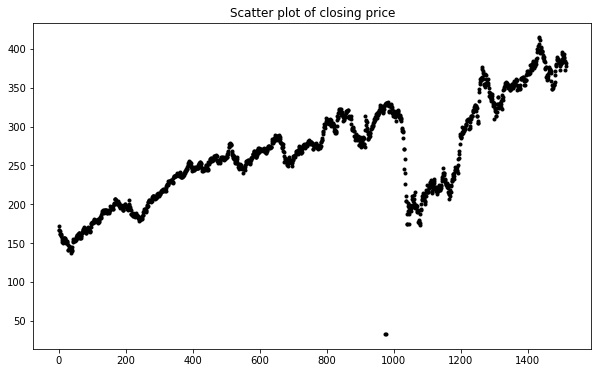

In [77]:
plt.figure(figsize=(10,6))
df_close = df['Close']
df_close.plot(style='k.')
plt.title('Scatter plot of closing price')
plt.show()

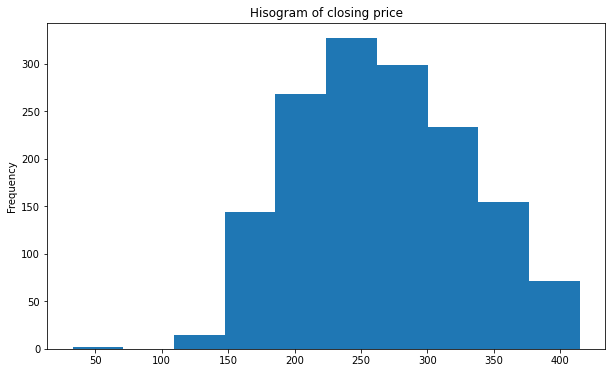

In [78]:
plt.figure(figsize=(10,6))
df_close = df['Close']
df_close.plot(style='k.',kind='hist')
plt.title('Hisogram of closing price')
plt.show()

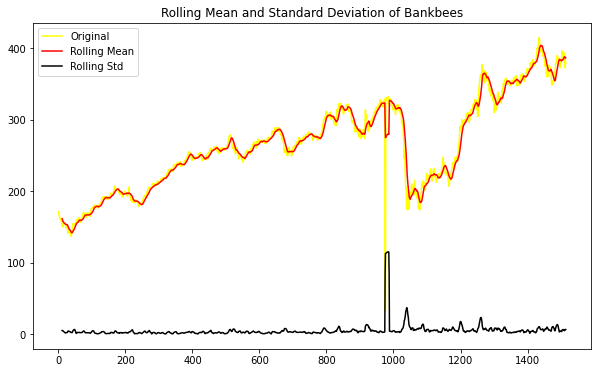

Results of dickey fuller test
Test Statistics                  -1.307638
p-value                           0.625671
No. of lags used                 10.000000
Number of observations used    1504.000000
critical value (1%)              -3.434705
critical value (5%)              -2.863464
critical value (10%)             -2.567794
dtype: float64


In [79]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='yellow',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation of Bankbees')
    plt.show(block=False)
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)

test_stationarity(df['Close'])

<Figure size 720x432 with 0 Axes>

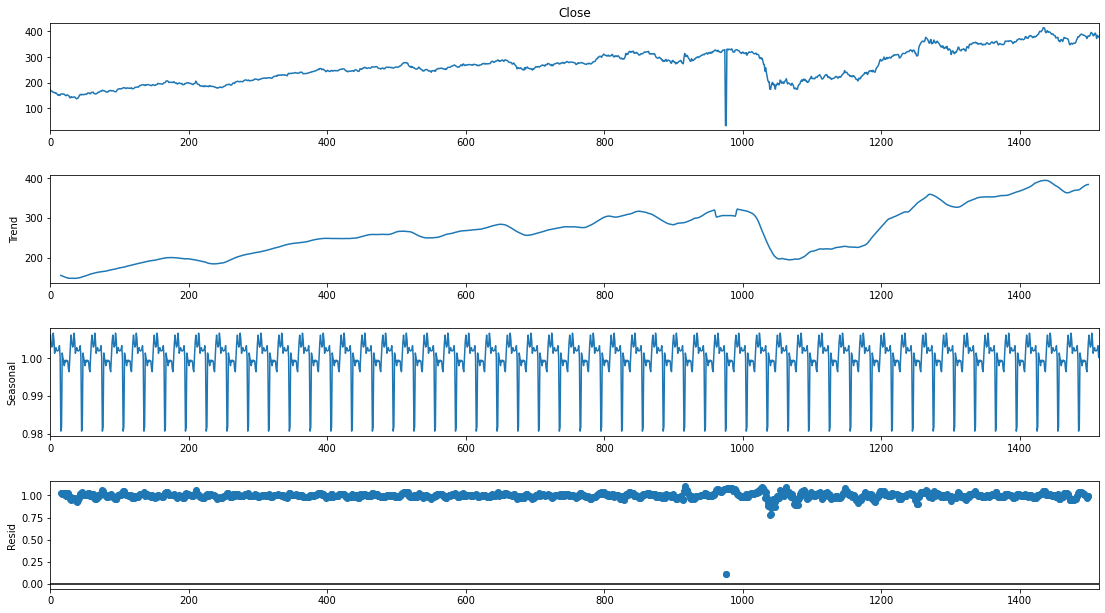

In [153]:
result = seasonal_decompose(df_close, model='multiplicative', freq = 30)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(16, 9)

No handles with labels found to put in legend.


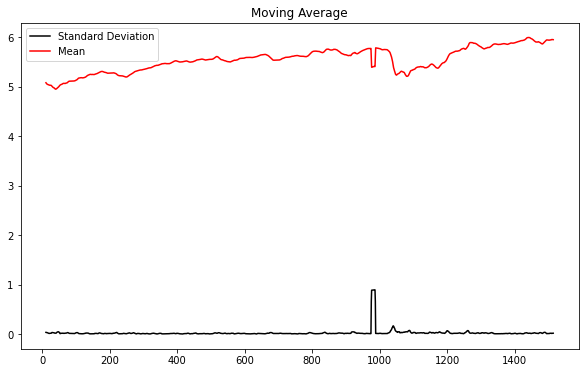

In [154]:
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
df_log = np.log(df['Close'])
moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend()
plt.show()

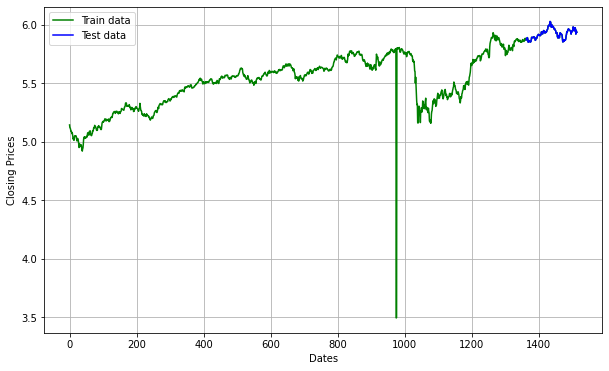

In [155]:
train_data, test_data = df_log[3:int(len(df_log)*0.9)], df_log[int(len(df_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_log, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()

In [156]:
model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
test='adf',       # use adftest to find optimal 'd'
max_p=3, max_q=3, # maximum p and q
m=1,              # frequency of series
d=None,           # let model determine 'd'
seasonal=False,   # No Seasonality
start_P=0, 
D=0, 
trace=True,
error_action='ignore',  
suppress_warnings=True, 
stepwise=True)
print(model_autoARIMA.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-2696.138, Time=0.51 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-2694.139, Time=0.31 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-2694.145, Time=0.38 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-2698.085, Time=0.28 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-2971.616, Time=3.25 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-3125.265, Time=2.85 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-3061.558, Time=0.82 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-3198.688, Time=5.35 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-3059.597, Time=0.47 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-3349.248, Time=5.79 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-3351.225, Time=4.33 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-3353.179, Time=5.02 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-3355.066, Time=2.01 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-3353.180, Time=3.68 sec
 ARIMA(1,1,3)(0,0,0

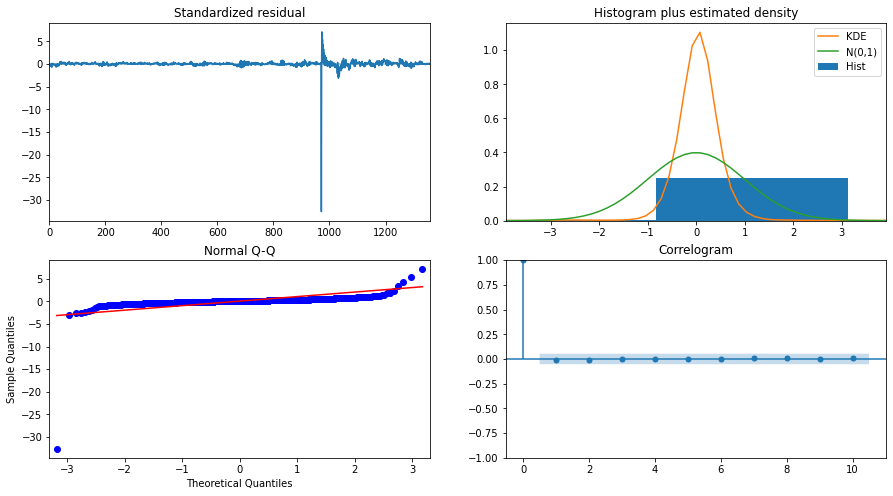

In [157]:
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

In [158]:
model = ARIMA(train_data, order=(3, 1, 2))
fitted = model.fit(disp=-1)
print(fitted.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 1359
Model:                 ARIMA(3, 1, 2)   Log Likelihood                1681.628
Method:                       css-mle   S.D. of innovations              0.070
Date:                Sat, 26 Feb 2022   AIC                          -3349.257
Time:                        16:54:50   BIC                          -3312.755
Sample:                             1   HQIC                         -3335.591
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0006      0.000      1.241      0.215      -0.000       0.002
ar.L1.D.Close    -0.0152      0.039     -0.393      0.695      -0.091       0.061
ar.L2.D.Close    -0.0080      0.035     

In [159]:
fc, se, conf = fitted.forecast(152, alpha=0.05)

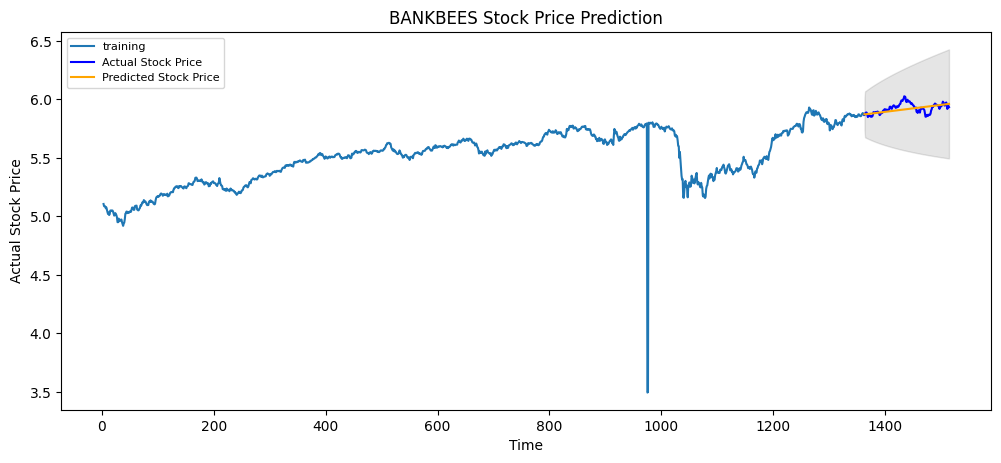

In [160]:
fc_series = pd.Series(fc, index=test_data.index)
lower_series = pd.Series(conf[:, 0], index=test_data.index)
upper_series = pd.Series(conf[:, 1], index=test_data.index)
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, color = 'blue', label='Actual Stock Price')
plt.plot(fc_series, color = 'orange',label='Predicted Stock Price')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.10)
plt.title('BANKBEES Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Actual Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [161]:
from sklearn.metrics import  mean_squared_error
rmse = mean_squared_error(test_data,fc_series,squared=False)
print(rmse)

0.03954740560277214


In [162]:
mape=np.mean(np.abs((test_data - fc_series) / test_data)) * 100
mape

0.5004078713447309

In [168]:
# DataFrame using arrays.
import pandas as pd
 
# initialize data of lists.
data = {'RMSE-(ARIMA Model)':[0.087198408,
0.065673816,
0.063868501,
0.109031557,
0.096046463,
0.051939413,
0.075440907,
0.173366127,
0.058234489,
0.039547406],
        'MAPE-(ARIMA Model)':[0.836956463,
0.848858056,
0.609825001,
1.229527697,
1.3101093717949364,
0.376995108,
0.723738626,
2.180935306,
0.9160138941986515,
0.500407871]}
 
# Creates pandas DataFrame.
df1 = pd.DataFrame(data, index =['RELIANCE',
                                'CIPLA',
                                'MARUTI',
                                'HUL','ICICI BANK','NESTLE IND','TCS','RAMCO CEMENT','NIFTYBEES','BANKBEES'])
 
# print the data
df1

RMSE-(ARIMA Model)  MAPE-(ARIMA Model)
RELIANCE                0.087198            0.836956
CIPLA                   0.065674            0.848858
MARUTI                  0.063869            0.609825
HUL                     0.109032            1.229528
ICICI BANK              0.096046            1.310109
NESTLE IND              0.051939            0.376995
TCS                     0.075441            0.723739
RAMCO CEMENT            0.173366            2.180935
NIFTYBEES               0.058234            0.916014
BANKBEES                0.039547            0.500408